# Gaussian surface approximation code
Code to loop through all the images for a city and return a data frame of the Gaussian fit parameters and dates

In [ ]:
# VI indices removed- will be calculated separately
# Optimised so the coordinate grid does not need to be created for every image

In [60]:
# Import packages
import os
import re  # regular expressions for getting lat lon grid
import pathlib
import warnings
#import gdal
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio as rio # for extracting subsets
from rasterio.plot import plotting_extent #for plotting
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em
import pandas as pd
import pickle
import matplotlib.patches as mpatches
import fnmatch  #for finding other file when city+rural isn't all in the main one (bulawayo)

#for the reprojecting
import pyproj
from pyproj import CRS
from pyproj import Transformer
import cartopy
import cartopy.crs as ccrs
from shapely.geometry import Point, LineString, Polygon
from pyhdf.SD import SD, SDC
import datetime as dt
import scipy
from scipy import interpolate
import geopandas as gpd

#Regression packages (used for linear and polynomial regression)
import operator
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

#for root finding and curve fitting
from scipy import optimize
from scipy.optimize import curve_fit

#for converting angles from radians to degrees
import math

#for computing the RMSE
from sklearn.metrics import mean_squared_error

# for plotting
from matplotlib import ticker 
from matplotlib.ticker import MaxNLocator


warnings.simplefilter('ignore')

#load in csv of city lons and lats
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','CITY_ADD_2022_09'))

CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx')  
CITY_COUNTRY_lat_lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon.Area_2002 >4]

In [54]:
##DEFINE FUNCTIONS

#Define functions for bit flag interpretation
#bit flag interpretation
#Defining QC functions
#function to check the status of a byte on the QC control
#x is the number to interrogate, n is the bit number to check
def check_bits(x,n):
    if (x & (1<<n)): 
  ## n-th bit is 1 
        flag = 1
    else:
  ## n-th bit is 0
        flag = 0
    return flag

#function to check bytes 1 and 2 and return 0 if they are both 0
def quality_control(x):
    if ((check_bits(x,1) == 0) and (check_bits(x,2) == 0)):
  ##if bit 1 and bit 2 are 0 then 0 
        flag = 0
    else:
  ##otherwise flag is 1
        flag = 1
    return flag    


#function to extract the subdatasets of interest and return a dataframe 
#QC is still needed as the pixels which are of bad quality will still need to be removed/ masked 

def dataframe_create(file_name):#, city_top):
    #Set path to chosen satellite
    #if city_top == 'Y':
    #    os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, 'CITY_TOP', SATELLITE))
    #else:    
    #    os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, SATELLITE))
    #path to the file
    data_path = os.path.join(file_name)
    #LST daytime
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:LST_Day_1km*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    LST_day = subdataset.read(1)
                
    #LST night       
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:LST_Night_1km*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    LST_night = subdataset.read(1)                
                
                
    #QC day      
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:QC_Day*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    QC_day = subdataset.read(1)   
                
    #QC night       
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:QC_Night*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    QC_night = subdataset.read(1)   
                
                
    #Create the coordinate grid
    # Identify the data field- use the LST day but grid is same for all data
    DATAFIELD_NAME = 'LST_Day_1km'

    GRID_NAME = 'MODIS_Grid_8Day_1km_LST'
    
    #if city_top == 'Y':
        #os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, 'CITY_TOP', SATELLITE))
    #else:    
    #os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, SATELLITE))
    
    hdf = SD(file_name, SDC.READ)

    # Read dataset.
    data2D = hdf.select(DATAFIELD_NAME)
    data = data2D[:,:].astype(np.float64)

    # Read global attribute.
    fattrs = hdf.attributes(full=1)
    ga = fattrs["StructMetadata.0"]
    gridmeta = ga[0]

    # Construct the grid.  Required information in global attribute called 'StructMetadata.0'

    ul_regex = re.compile(r'''UpperLeftPointMtrs=\(
                                  (?P<upper_left_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<upper_left_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
    match = ul_regex.search(gridmeta)
    x0 = np.float(match.group('upper_left_x')) 
    y0 = np.float(match.group('upper_left_y')) 

    lr_regex = re.compile(r'''LowerRightMtrs=\(
                                  (?P<lower_right_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<lower_right_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
    match = lr_regex.search(gridmeta)
    x1 = np.float(match.group('lower_right_x')) 
    y1 = np.float(match.group('lower_right_y')) 
    ny, nx = data.shape
    xinc = (x1 - x0) / nx
    yinc = (y1 - y0) / ny

    x = np.linspace(x0, x0 + xinc*nx, nx)
    y = np.linspace(y0, y0 + yinc*ny, ny)
    xv, yv = np.meshgrid(x, y)

    # convert the grid back to lat/lons.
    transformer = Transformer.from_crs("+proj=sinu +R=6371007.181 +nadgrids=@null +wktext", "EPSG:4326")
    lat, lon = transformer.transform(xv, yv)

    #Apply scale factors
    scale_factor_LST = 0.02

    LST_day = LST_day*scale_factor_LST
    LST_night = LST_night*scale_factor_LST

    #Note: fill value for LST is 0

    #Create the lists to be combined to create a dataframe
    LST_day_list = LST_day.flatten()
    LST_night_list = LST_night.flatten()
    QC_day_list = QC_day.flatten()
    QC_night_list = QC_night.flatten()
    Lon_list = lon.flatten()
    Lat_list = lat.flatten()

    #Create the dataframe

    df = pd.DataFrame(list(zip(LST_day_list, LST_night_list, QC_day_list, QC_night_list, Lon_list, Lat_list)), 
               columns =['LST_day', 'LST_night','QC_day', 'QC_night','Longitude', 'Latitude']) 
    
    #Create dataframe of the required area
    df_subset = df[(df.Latitude >= min_lat) & (df.Latitude <= max_lat) & (df.Longitude >= min_lon) & (
        df.Longitude <= max_lon)]
    df_subset = df_subset.sort_values(by=['Latitude', 'Longitude']).reset_index(drop = True)
    
    return df_subset

#Define the function for the Gaussian surface
def SUHIfunc(Z,a0,x0,y0,phi,ax,ay):
    x,y = Z
    return a0 * np.exp(((-((x-x0)*np.cos(phi)+(y-y0)*np.sin(phi))**2)/(0.5*(ax**2)))
                       -((((y-y0)*np.cos(phi)-(x-x0)*np.sin(phi))**2)/(0.5*(ay**2))))

#function for transforming angle in radians to degrees
def rad_to_deg(angle):
    deg = math.degrees(angle)
    deg = deg % 360
    if deg > 180:
        deg = deg - 360
    return deg


### The below functions have been added to optimise the code - the coordinate grid is only generated once #####
### as it is the same for all the images                                                                  #####

def data_extract(file_name, Lat_list, Lon_list):#, city_top):
    #Set path to chosen satellite
    #path to the file
    data_path = os.path.join(file_name)
    #LST daytime
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:LST_Day_1km*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    LST_day = subdataset.read(1)
                
    #LST night       
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:LST_Night_1km*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    LST_night = subdataset.read(1)                
                
                
    #QC day      
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:QC_Day*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    QC_day = subdataset.read(1)   
                
    #QC night       
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:QC_Night*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    QC_night = subdataset.read(1)   

                    
    #Apply scale factors
    scale_factor_LST = 0.02

    LST_day = LST_day*scale_factor_LST
    LST_night = LST_night*scale_factor_LST

    #Note: fill value for LST is 0

    #Create the lists to be combined to create a dataframe
    LST_day_list = LST_day.flatten()
    LST_night_list = LST_night.flatten()
    QC_day_list = QC_day.flatten()
    QC_night_list = QC_night.flatten()                
    
    #Create the dataframe

    df = pd.DataFrame(list(zip(LST_day_list, LST_night_list, QC_day_list, QC_night_list, Lon_list, Lat_list)), 
               columns =['LST_day', 'LST_night','QC_day', 'QC_night','Longitude', 'Latitude']) 
    
    #Create dataframe of the required area
    df_subset = df[(df.Latitude >= min_lat) & (df.Latitude <= max_lat) & (df.Longitude >= min_lon) & (
        df.Longitude <= max_lon)]
    df_subset = df_subset.sort_values(by=['Latitude', 'Longitude']).reset_index(drop = True)
    
    return df_subset
    
def coord_grid_create(SATELLITE, file_name):#, city_top):          
    #Create the coordinate grid
    # Identify the data field- use the LST day but grid is same for all data
    DATAFIELD_NAME = 'LST_Day_1km'

    GRID_NAME = 'MODIS_Grid_8Day_1km_LST'
    
    hdf = SD(file_name, SDC.READ)

    # Read dataset.
    data2D = hdf.select(DATAFIELD_NAME)
    data = data2D[:,:].astype(np.float64)

    # Read global attribute.
    fattrs = hdf.attributes(full=1)
    ga = fattrs["StructMetadata.0"]
    gridmeta = ga[0]

    # Construct the grid.  Required information in global attribute called 'StructMetadata.0'

    ul_regex = re.compile(r'''UpperLeftPointMtrs=\(
                                  (?P<upper_left_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<upper_left_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
    match = ul_regex.search(gridmeta)
    x0 = np.float(match.group('upper_left_x')) 
    y0 = np.float(match.group('upper_left_y')) 

    lr_regex = re.compile(r'''LowerRightMtrs=\(
                                  (?P<lower_right_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<lower_right_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
    match = lr_regex.search(gridmeta)
    x1 = np.float(match.group('lower_right_x')) 
    y1 = np.float(match.group('lower_right_y')) 
    ny, nx = data.shape
    xinc = (x1 - x0) / nx
    yinc = (y1 - y0) / ny

    x = np.linspace(x0, x0 + xinc*nx, nx)
    y = np.linspace(y0, y0 + yinc*ny, ny)
    xv, yv = np.meshgrid(x, y)

    # convert the grid back to lat/lons.
    transformer = Transformer.from_crs("+proj=sinu +R=6371007.181 +nadgrids=@null +wktext", "EPSG:4326")
    lat, lon = transformer.transform(xv, yv)

    #Create the lists to be combined to create a dataframe

    Lon_list = lon.flatten()
    Lat_list = lat.flatten()
    
    return Lon_list, Lat_list

#function for finding the UTM projection
def utm_zoner(lon, lat):
    utm_lon = lon+180
    utm_zone = int(np.ceil(utm_lon/6))
    south_hem =''
    if lat<0:
        south_hem = ' +south'
    proj_str = f'+proj=utm +zone={utm_zone}{south_hem}'
    return proj_str

In [58]:
plt.style.use('default')

#create lists for the quality checks 
day_corr_list = []
day_rmse_list = []
day_a0_std_list = []
day_x0_std_list = []
day_y0_std_list = []
day_phi_std_list = []
day_ax_std_list = []
day_ay_list = []
day_quantile_a0_list = []
day_num_no_fits_list = []
day_total_list = []

night_corr_list = []
night_rmse_list = []
night_a0_std_list = []
night_x0_std_list = []
night_y0_std_list = []
night_phi_std_list = []
night_ax_std_list = []
night_ay_list = []
night_quantile_a0_list = []
night_num_no_fits_list = []
night_total_list = []

for count, CITY_COUNTRY in enumerate(CITY_COUNTRY_lat_lon.CITY_COUNTRY):
    #if CITY_COUNTRY == "BULAWAYO_ZIMBABWE":
    #    two_images = True
    #else:
    #    two_images = False
    #SATELLITE = 'MOD11A2' #TERRA
    SATELLITE = 'MYD11A2' #AQUA

    #Identify names/ values of chosen city
    #set the city latitude and longitudes and city name
    City_Lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lat'].values[0]
    City_Lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lon'].values[0]
    City_name = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City'].values[0]
    City_area = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Area'].values[0]
    City_bound_xmin = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_xmin'].values[0]/1000
    City_bound_xmax = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_xmax'].values[0]/1000
    City_bound_ymin = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_ymin'].values[0]/1000
    City_bound_ymax = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_ymax'].values[0]/1000
    min_lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['min_lat'].values[0]
    max_lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['max_lat'].values[0]
    min_lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['min_lon'].values[0]
    max_lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['max_lon'].values[0]
    Grid_Ref = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Grid_Ref'].values[0]
    #city extent bound used as constraint. Used 2*sqrt(city_area) +2
    City_extent_bound = 2*np.sqrt(City_area) + 2

    #create satellite name for plots
    if SATELLITE == 'MOD11A2':
        satellite_name = 'Terra'
    else:
        satellite_name = 'Aqua'
    
    #Load in LULC data, these bases were created in JASMIN, then cropped to correct size and 5km buffer flag added
    os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
    with open('UHI_Project_Pickle_Files\LULC_Pickles\Crop_wbuffer_LULC\LULC_{}.pkl'.format(CITY_COUNTRY), 'rb') as f:
         LULC_df = pickle.load(f)
    #sort values to ensure in correct order        
    LULC_df = LULC_df.sort_values(by=['Latitude', 'Longitude']).reset_index(drop = True)   

    os.chdir(os.path.join('E:\\','City_Data','MODIS_8_day_LST',CITY_COUNTRY, SATELLITE))
    #set path to current directory
    path = pathlib.Path().absolute()

    #Read pickle files back in from image select code. These will the be looped through
    
    with open('Day_list.pkl', 'rb') as f:
        Day_list = pickle.load(f)
    
    with open('Night_list.pkl', 'rb') as f:
        Night_list = pickle.load(f)
    
    #if two_images == True:
        #with open('Day_list_top_file.pkl', 'rb') as f:
            #Day_list_top_file = pickle.load(f)
    
        #with open('Night_list_top_file.pkl', 'rb') as f:
            #Night_list_top_file = pickle.load(f)

    #Set path to chosen satellite
    os.chdir(os.path.join('E:\\','Grid_Refs',Grid_Ref, SATELLITE))
    
    #Create the dataframe, contains the filenames and columns to be filled
    parameters_df = pd.DataFrame(data = Day_list, columns = ['Filename'])
    parameters_df['Date'] = np.nan
    parameters_df['Year'] = np.nan
    parameters_df['Month'] = np.nan
    parameters_df['day_a0'] = np.nan
    parameters_df['day_x0'] = np.nan
    parameters_df['day_y0'] = np.nan
    parameters_df['day_phi'] = np.nan
    parameters_df['day_ax'] = np.nan
    parameters_df['day_ay'] = np.nan
    parameters_df['footprint_area'] = np.nan
    parameters_df['day_std_dev_a0'] = np.nan
    parameters_df['day_std_dev_x0'] = np.nan
    parameters_df['day_std_dev_y0'] = np.nan
    parameters_df['day_std_dev_phi'] = np.nan
    parameters_df['day_std_dev_ax'] = np.nan
    parameters_df['day_std_dev_ay'] = np.nan
    parameters_df['corr'] = np.nan
    parameters_df['rmse'] = np.nan
    parameters_df['method_1_SUHI'] = np.nan
    parameters_df['method_2_SUHI'] = np.nan
    parameters_df['buffer_5km_SUHI'] = np.nan
    parameters_df['quantile_a0'] = np.nan
    parameters_df['quantile_75'] = np.nan
    parameters_df['city_pixels_used'] = np.nan
    parameters_df['rural_corr'] = np.nan
    parameters_df['eccentricity'] = np.nan

    #night 
    parameters_night_df = pd.DataFrame(data = Night_list, columns = ['Filename'])
    parameters_night_df['Date'] = np.nan
    parameters_night_df['Year'] = np.nan
    parameters_night_df['Month'] = np.nan
    parameters_night_df['night_a0'] = np.nan
    parameters_night_df['night_x0'] = np.nan
    parameters_night_df['night_y0'] = np.nan
    parameters_night_df['night_phi'] = np.nan
    parameters_night_df['night_ax'] = np.nan
    parameters_night_df['night_ay'] = np.nan
    parameters_night_df['footprint_area'] = np.nan
    parameters_night_df['night_std_dev_a0'] = np.nan
    parameters_night_df['night_std_dev_x0'] = np.nan
    parameters_night_df['night_std_dev_y0'] = np.nan
    parameters_night_df['night_std_dev_phi'] = np.nan
    parameters_night_df['night_std_dev_ax'] = np.nan
    parameters_night_df['night_std_dev_ay'] = np.nan
    parameters_night_df['corr'] = np.nan
    parameters_night_df['rmse'] = np.nan
    parameters_night_df['method_1_SUHI'] = np.nan
    parameters_night_df['method_2_SUHI'] = np.nan
    parameters_night_df['buffer_5km_SUHI'] = np.nan
    parameters_night_df['quantile_a0'] = np.nan
    parameters_night_df['quantile_75'] = np.nan
    parameters_night_df['rural_corr'] = np.nan
    parameters_night_df['eccentricity'] = np.nan

    #Change the coordinate reference system
    #lat and lon coordinates are not accurate as they are distorted by the shape of the map
    #create a coordinate base

    #file to create base from chosen at random, all coord grid are the same so doesn't matter
    file_name = Day_list[7]
    df_subset = dataframe_create(file_name)#, city_top = 'N')

    if CITY_COUNTRY in(["BULAWAYO_ZIMBABWE",'RIO_BRANCO_BRAZIL','SANHE_CHINA','DAYTON_USA']):
        if CITY_COUNTRY == "BULAWAYO_ZIMBABWE":
            Grid_Ref_top = 'h20v10'
        elif CITY_COUNTRY == 'RIO_BRANCO_BRAZIL':
            Grid_Ref_top = 'h11v10'  
        elif CITY_COUNTRY == 'SANHE_CHINA':
            Grid_Ref_top = 'h26v04'
        elif CITY_COUNTRY == 'DAYTON_USA':
            Grid_Ref_top = 'h11v04'
        #add in other files for cities where the rural extent goes outside of the grid box    
        #extract the julian date of the main filename
        yeardoy = file_name.split('.')[1][1:] 
        #Set path to chosen satellite
        os.chdir(os.path.join('E:\\','Grid_Refs', Grid_Ref_top, SATELLITE))
        #find the filename which contains this in the top of city files
        for file in os.listdir('.'):
            if fnmatch.fnmatch(file, '*{}*'.format(yeardoy)):
                top_file_name = file    
    
        top_file_df = dataframe_create(top_file_name)#, city_top = 'Y')
        df_subset = df_subset.append(top_file_df).reset_index(drop = True)
        df_subset = df_subset.sort_values(by=['Latitude', 'Longitude']).reset_index(drop = True)
        #set path back
        os.chdir(os.path.join('E:\\','Grid_Refs',Grid_Ref, SATELLITE))

    #Get the UTM of the city
    local_utm = CRS.from_proj4(utm_zoner(City_Lon, City_Lat))

    #get geometry of the subset
    df_subset_geometry = [Point(xy) for xy in zip(df_subset.Longitude, df_subset.Latitude)]

    #transform into a geopandas dataframe
    gdf = gpd.GeoDataFrame(df_subset, geometry=df_subset_geometry)
    gdf.crs= {'init': 'epsg:4326', 'no_defs': True}

    gdf2 = gdf.to_crs(epsg=local_utm.to_epsg()).copy() #create a new geo dataframe, with units in m, cartesian 2D axis 

    #origin coordinates - take to be city centre
    #create a data frame with origin points
    origin_df = pd.DataFrame(
        {'City': [CITY_COUNTRY],
         'Latitude': [City_Lat],
         'Longitude': [City_Lon]})

    origin_df_geometry = [Point(xy) for xy in zip(origin_df.Longitude, origin_df.Latitude)]

    origin_gdf = gpd.GeoDataFrame(origin_df, geometry=origin_df_geometry)

    origin_gdf.crs= {'init': 'epsg:4326', 'no_defs': True}
    origin_gdf = origin_gdf.to_crs(epsg=local_utm.to_epsg())

    #Now change the grid so the the origin is the city centre 

    #Extract the x and y coordinates 
    x_points = gdf2['geometry'].x
    y_points = gdf2['geometry'].y

    #and add the extracted coordinates to dataframe
    gdf2['xpoints'] = x_points
    gdf2['ypoints'] = y_points

    #Determine the origin (city centre)
    origin_x = origin_gdf['geometry'].x
    origin_y = origin_gdf['geometry'].y

    #Subtract the orgin from the points and convert to km
    gdf2['x_points'] = (gdf2['xpoints'] - origin_x.values) / 1000
    gdf2['y_points'] = (gdf2['ypoints'] - origin_y.values) / 1000

    #Drop the xpoints and ypoints columns as they are no longer needed
    gdf2 = gdf2.drop('xpoints', axis = 1)
    gdf2 = gdf2.drop('ypoints', axis = 1)

    #create a base of the x points and y points so don't have to generate this for every individual file, as will be the same
    x_points = gdf2.x_points.values
    y_points = gdf2.y_points.values

    #### Create the Lat and Lon lists ####
    Lon_list, Lat_list = coord_grid_create(SATELLITE, file_name)#, city_top = 'N')
    
    if CITY_COUNTRY in(["BULAWAYO_ZIMBABWE",'RIO_BRANCO_BRAZIL','SANHE_CHINA','DAYTON_USA']):
        if CITY_COUNTRY == "BULAWAYO_ZIMBABWE":
            Grid_Ref_top = 'h20v10'
        elif CITY_COUNTRY == 'RIO_BRANCO_BRAZIL':
            Grid_Ref_top = 'h11v10'  
        elif CITY_COUNTRY == 'SANHE_CHINA':
            Grid_Ref_top = 'h26v04'
        elif CITY_COUNTRY == 'DAYTON_USA':
            Grid_Ref_top = 'h11v04'
        #add in other files for cities where the rural extent goes outside of the grid box    
        #extract the julian date of the main filename
        yeardoy = file_name.split('.')[1][1:] 
        #Set path to chosen satellite
        os.chdir(os.path.join('E:\\','Grid_Refs', Grid_Ref_top, SATELLITE))
        #find the filename which contains this in the top of city files
        for file in os.listdir('.'):
            if fnmatch.fnmatch(file, '*{}*'.format(yeardoy)):
                top_file_name = file    
    
        Lon_list_top, Lat_list_top = coord_grid_create(SATELLITE, top_file_name)
        #set path back
        os.chdir(os.path.join('E:\\','Grid_Refs',Grid_Ref, SATELLITE))
    
    #loop through the QC list and calculate the parameters
    #Runtime: 45 mins

    for i in range(len(Day_list)):
        os.chdir(os.path.join('E:\\','Grid_Refs',Grid_Ref, SATELLITE)) #make sure correct filepath
        file_name = Day_list[i]

        df_subset = data_extract(file_name, Lat_list, Lon_list )
        #add in other files for cities where the rural extent goes outside of the grid box    
    
        if CITY_COUNTRY in(["BULAWAYO_ZIMBABWE",'RIO_BRANCO_BRAZIL','SANHE_CHINA','DAYTON_USA']):
            if CITY_COUNTRY == "BULAWAYO_ZIMBABWE":
                Grid_Ref_top = 'h20v10'
            elif CITY_COUNTRY == 'RIO_BRANCO_BRAZIL':
                Grid_Ref_top = 'h11v10'  
            elif CITY_COUNTRY == 'SANHE_CHINA':
                Grid_Ref_top = 'h26v04'
            elif CITY_COUNTRY == 'DAYTON_USA':
                Grid_Ref_top = 'h11v04'
            #add in other files for cities where the rural extent goes outside of the grid box   
            #Set path to chosen satellite
            os.chdir(os.path.join('E:\\','Grid_Refs', Grid_Ref_top, SATELLITE))
    
            #extract the julian date of the main filename
            yeardoy = file_name.split('.')[1][1:] 

            #find the filename which contains this in the top of city files
            for file in os.listdir('.'):
                if fnmatch.fnmatch(file, '*{}*'.format(yeardoy)):
                    top_file_name = file    
    
            top_file_df = data_extract(top_file_name, Lat_list_top, Lon_list_top)
            
            df_subset = df_subset.append(top_file_df).reset_index(drop = True)
            df_subset = df_subset.sort_values(by=['Latitude', 'Longitude']).reset_index(drop = True) 
            #set path back
            os.chdir(os.path.join('E:\\','Grid_Refs',Grid_Ref, SATELLITE))
    
        yeardoy = file_name.split('.')[1][1:]                               # Split filename to retrieve acquisition date
        date = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%d/%m/%Y') 
        year = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%Y') 
        month = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%m') 

        #add in the x y coords
        df_subset['x_points'] = x_points
        df_subset['y_points'] = y_points

        #add a translated QC flag (where 0 is usuable, 1 not usable) 
        #apply QC function to dataframe (function checks that the first 2 bytes of the QC flag are 0, which means its good quality)
        QC_day2 = np.array([quality_control(int(i)) for i in df_subset.QC_day])

        #add this QC2 flag onto the dataset
        df_subset['QC_day2'] = QC_day2
        
        #add in the urban classification
        #going to remove 2021 anyway so doesn't matter its not accurate
        if year in ('2021','2022'):
            year2 = '2020'
        else:
            year2 = year
        #add in urban classification to check for urban land    
        df_subset['is_urban'] = LULC_df['is_urban_overall_{}'.format(year2)].values
    
        #add in lccs classification 2015 to check for waterbodies 
        df_subset['lccs_class_overall_2015'] = LULC_df['lccs_class_overall_2015'].values
    
        #add in buffer area flag
        df_subset['buffer'] = LULC_df['buffer'].values
    
        #outside of city area and urban
        df_drop = df_subset[((df_subset['x_points'] < City_bound_xmin) | (df_subset['x_points'] > City_bound_xmax) 
                             | (df_subset['y_points'] < City_bound_ymin) | (df_subset['y_points'] > City_bound_ymax)
                      ) & (df_subset['is_urban'] == 1)]

        #remove the areas which are urban but outside the city from the analysis
        df_subset = df_subset.drop(df_drop.index)
    
        #remove water bodies 
        df_drop = df_subset[(df_subset['lccs_class_overall_2015'] == 210)]
        df_subset = df_subset.drop(df_drop.index)
    
        #the urban classification and QC2 flag used to apply mask to the urban areas and the areas with QC2 flag = 1
        #remove the pixels which are not of good quality from the dataset
        df_day_gq = df_subset[df_subset['QC_day2'] == 0].copy()

        #take out the urban pixels and apply the linear regression

        #Extract rural df for the daytime and nighttime images
        df_rural_day = df_day_gq[df_day_gq['is_urban'] == 0][['LST_day','x_points', 'y_points']].copy()

        #will then apply a mulitple linear regression (with 2 variables, x and y) to this subset to get something of the form
        # LST = T0 + (a1)x + (a2)y
        #T0, a1, a2 coefficients to be determined

        #Perform regression
        #Divide the data into attributes and labels
        #rural daytime
        X = df_rural_day[['x_points','y_points']].values
        y = df_rural_day['LST_day'].values

        #Split the data, 80% to training set, 20% to test set - do I want to do this?? The fit is not examined so leave out for now
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 0)
        #regressor.fit(X_train, y_train)

        #Fit the model to the training set
        regressor = LinearRegression()
        regressor.fit(X, y)

        #Use the regression to predict T_0
        #This will give a baseline for what the temperature would be in the urban area if it was rural

        #create the column T_0 with the predicted rural baseline temperatures
        pred_input = df_day_gq[['x_points','y_points']].values
        df_day_gq['T_0_pred'] = regressor.predict(pred_input)

        #get the correlation of the rural regression
        rur_est = regressor.predict(X)    
        rur_r = np.corrcoef(rur_est, y)[0,1]
    
        #Take the predicted baseline temperature away from the LST to get the SUHI footprint 
        df_day_gq['SUHI'] = df_day_gq['LST_day'] - df_day_gq['T_0_pred']
    
        #set initial guess parameters
        #p0 = a0, x0, y0, phi, ax, ay 
        #choose a0 as half max SUHI, (x0,y0) as city centre, phi as 0 deg, (ax,ay) as square box around city area
    
        day_p0 = 0.5*max(df_day_gq['SUHI']), 0, 0, 0, 0.5*np.sqrt(City_area), 0.5*np.sqrt(City_area)
    
        #fit the data to the Gaussian surface 
        #daytime SUHI
        x = df_day_gq['x_points'].values
        y = df_day_gq['y_points'].values
        z = df_day_gq['SUHI'].values

        try:
    
            day_popt, day_pcov = curve_fit(SUHIfunc, (x,y), z, day_p0, 
                                   bounds = ((-np.inf, 0.6*City_bound_xmin, 0.6*City_bound_ymin, -np.inf, 
                                              -City_extent_bound, -City_extent_bound),
                                         (np.inf, 0.6*City_bound_xmax, 0.6*City_bound_ymax, np.inf, City_extent_bound
                                          , City_extent_bound))
                                   ,maxfev=5000, jac = None)
    
            day_perr = np.sqrt(np.diag(day_pcov)) #standard deviation on parameters

        except RuntimeError:
            day_popt = day_pcov = day_perr = (np.nan , np.nan , np.nan, np.nan, np.nan, np.nan)
        
        else:
            day_popt, day_pcov = curve_fit(SUHIfunc, (x,y), z, day_p0, 
                                   bounds = ((-np.inf, 0.6*City_bound_xmin, 0.6*City_bound_ymin, -np.inf, 
                                              -City_extent_bound, -City_extent_bound),
                                         (np.inf, 0.6*City_bound_xmax, 0.6*City_bound_ymax, np.inf
                                          , City_extent_bound, City_extent_bound))
                                   ,maxfev=5000, jac = None)
    
            day_perr = np.sqrt(np.diag(day_pcov)) #standard deviation on parameters
        
        #calculate correlation coefficient for the GSA and the SUHI
        x_city = df_day_gq[(df_day_gq['x_points'] > City_bound_xmin) & (df_day_gq['x_points'] < City_bound_xmax) 
                       & (df_day_gq['y_points'] > City_bound_ymin) 
                       & (df_day_gq['y_points'] < City_bound_ymax)]['x_points'].values
        y_city = df_day_gq[(df_day_gq['x_points'] > City_bound_xmin) & (df_day_gq['x_points'] < City_bound_xmax) 
                       & (df_day_gq['y_points'] > City_bound_ymin) 
                       & (df_day_gq['y_points'] < City_bound_ymax)]['y_points'].values
        T_0_pred_city = df_day_gq[(df_day_gq['x_points'] > City_bound_xmin) & (df_day_gq['x_points'] < City_bound_xmax) 
                       & (df_day_gq['y_points'] > City_bound_ymin) 
                       & (df_day_gq['y_points'] < City_bound_ymax)]['T_0_pred'].values
        LST = df_day_gq[(df_day_gq['x_points'] > City_bound_xmin) & (df_day_gq['x_points'] < City_bound_xmax) 
                       & (df_day_gq['y_points'] > City_bound_ymin) 
                       & (df_day_gq['y_points'] < City_bound_ymax)]['LST_day'].values

        if np.isnan(day_popt[0]):
            r = np.nan
            rmse = np.nan
        elif not any(LST):    #in cases where the LST section is empty (too many pixels removed in city area)
            r = np.nan
            rmse = np.nan
        else:
            GSA_SUHI = SUHIfunc((x_city,y_city), day_popt[0], day_popt[1],day_popt[2],day_popt[3],day_popt[4],day_popt[5])
            LST_est = GSA_SUHI + T_0_pred_city
            r = np.corrcoef(LST_est, LST)[0,1]  
            rmse = mean_squared_error(LST, LST_est, squared=False)
            
        #calculate other means
        #method 1: average SUHI of urban area, SUHI calculated by subtracting linear regression modelled rural temp
        #method 2: average SUHI calculated by taking mean LST of rural area from mean LST of urban area 
        mean_SUHI_m1 = df_day_gq[df_day_gq['is_urban'] == 1]['SUHI'].mean()
        mean_SUHI_m2 = df_day_gq[df_day_gq['is_urban'] == 1]['LST_day'].mean() - df_day_gq[df_day_gq['is_urban'] == 0]['LST_day'].mean()
    
        #buffer method: average temp of urban area minus average temp of buffer
        buffer_5km_SUHI = df_day_gq[df_day_gq['is_urban'] == 1]['LST_day'].mean() - df_day_gq[(
            (df_day_gq['is_urban'] == 0) & (df_day_gq['buffer'] == 1))]['LST_day'].mean()
    
        #calculate peak intensity based on quantiles
        #if the average SUHI is negative (urban cool island) take the 0.05 quantile
        rural_median = np.quantile(df_rural_day['LST_day'].values, 0.5)
    
        if not any(LST):
            quantile_a0 = np.nan
            pixels_used = 0
        else:
            if mean_SUHI_m2 < 0:
                urban_quantile_95 = np.quantile(LST, 0.05)
                urban_quantile_75 = np.quantile(LST, 0.25)
            else:
                urban_quantile_95 = np.quantile(LST, 0.95)
                urban_quantile_75 = np.quantile(LST, 0.75)
    
            quantile_a0 = urban_quantile_95 - rural_median
            quantile_75 = urban_quantile_75 - rural_median
        
            pixels_used = len(LST)   

        #update the a0 for the case the peak SUHI does not exist
        if np.isnan(day_popt[0]) and abs(mean_SUHI_m2) < 0.5:
            day_a0 = 0
        else:
            day_a0 = day_popt[0]
    
        parameters_df['Date'][i] = date
        parameters_df['Year'][i] = year
        parameters_df['Month'][i] = month
        parameters_df['day_a0'][i] = day_a0
        parameters_df['day_x0'][i] = day_popt[1]
        parameters_df['day_y0'][i] = day_popt[2]
        parameters_df['day_phi'][i] = rad_to_deg(day_popt[3])
        parameters_df['day_ax'][i] = day_popt[4]
        parameters_df['day_ay'][i] = day_popt[5]
        parameters_df['footprint_area'][i] = np.pi * abs(day_popt[4]) * abs(day_popt[5])
        parameters_df['day_std_dev_a0'][i] = day_perr[0]
        parameters_df['day_std_dev_x0'][i] = day_perr[1]
        parameters_df['day_std_dev_y0'][i] = day_perr[2]
        parameters_df['day_std_dev_phi'][i] = rad_to_deg(day_perr[3])
        parameters_df['day_std_dev_ax'][i] = day_perr[4]
        parameters_df['day_std_dev_ay'][i] = day_perr[5]
        parameters_df['corr'][i] = r
        parameters_df['rmse'][i] = rmse
        parameters_df['method_1_SUHI'][i] = mean_SUHI_m1
        parameters_df['method_2_SUHI'][i] = mean_SUHI_m2
        parameters_df['buffer_5km_SUHI'][i] = buffer_5km_SUHI
        parameters_df['quantile_a0'][i] = quantile_a0
        parameters_df['quantile_75'][i] = quantile_75
        parameters_df['city_pixels_used'][i] = pixels_used
        parameters_df['rural_corr'][i] = rur_r
        parameters_df['eccentricity'][i] = (np.sqrt(max(day_popt[1], day_popt[2])**2 - min(day_popt[1], day_popt[2])**2) 
                                        / max(day_popt[1], day_popt[2]))
    #where to save df
    os.chdir(os.path.join('E:\\','City_Data','MODIS_8_day_LST',CITY_COUNTRY, SATELLITE))
    #save the dataframe as a pickle
    pickle_name = 'Parameters_Day_inital_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'wb') as f:
        pickle.dump(parameters_df, f)
    
    #remove parameters which do not meet accuracy criteria    
    parameters_df_qu = parameters_df.copy()

    #correlation must be greater than 0.5
    parameters_df_qu.loc[(parameters_df_qu['corr'] < 0.5), 'day_a0'] = np.nan
    parameters_df_qu.loc[(parameters_df_qu['corr'] < 0.5), 'day_x0'] = np.nan
    parameters_df_qu.loc[(parameters_df_qu['corr'] < 0.5), 'day_y0'] = np.nan
    parameters_df_qu.loc[(parameters_df_qu['corr'] < 0.5), 'day_phi'] = np.nan
    parameters_df_qu.loc[(parameters_df_qu['corr'] < 0.5), 'day_ax'] = np.nan
    parameters_df_qu.loc[(parameters_df_qu['corr'] < 0.5), 'day_ay'] = np.nan
    parameters_df_qu.loc[(parameters_df_qu['corr'] < 0.5), 'footprint_area'] = np.nan

    #rmse must be less than 2.5K
    parameters_df_qu.loc[(parameters_df_qu['rmse'] > 2.5), 'day_a0'] = np.nan
    parameters_df_qu.loc[(parameters_df_qu['rmse'] > 2.5), 'day_x0'] = np.nan
    parameters_df_qu.loc[(parameters_df_qu['rmse'] > 2.5), 'day_y0'] = np.nan
    parameters_df_qu.loc[(parameters_df_qu['rmse'] > 2.5), 'day_phi'] = np.nan
    parameters_df_qu.loc[(parameters_df_qu['rmse'] > 2.5), 'day_ax'] = np.nan
    parameters_df_qu.loc[(parameters_df_qu['rmse'] > 2.5), 'day_ay'] = np.nan
    parameters_df_qu.loc[(parameters_df_qu['rmse'] > 2.5), 'footprint_area'] = np.nan


    #Remove the values for which the std deviation shows the fit to not have worked- no SUHI exists
    #remove based on a0
    #parameters_df_qu.loc[abs(parameters_df_qu['day_std_dev_a0'] / parameters_df_qu['day_a0']) > 1, 'day_x0'] = np.nan
    #parameters_df_qu.loc[abs(parameters_df_qu['day_std_dev_a0'] / parameters_df_qu['day_a0']) > 1, 'day_y0'] = np.nan
    #parameters_df_qu.loc[abs(parameters_df_qu['day_std_dev_a0'] / parameters_df_qu['day_a0']) > 1, 'day_phi'] = np.nan
    #parameters_df_qu.loc[abs(parameters_df_qu['day_std_dev_a0'] / parameters_df_qu['day_a0']) > 1, 'day_ax'] = np.nan
    #parameters_df_qu.loc[abs(parameters_df_qu['day_std_dev_a0'] / parameters_df_qu['day_a0']) > 1, 'day_ay'] = np.nan
    #parameters_df_qu.loc[abs(parameters_df_qu['day_std_dev_a0'] / parameters_df_qu['day_a0']) > 1, 'footprint_area'] = np.nan
    #have to run this one last as it is used to update the others
    #parameters_df_qu.loc[abs(parameters_df_qu['day_std_dev_a0'] / parameters_df_qu['day_a0']) > 1, 'day_a0'] = np.nan

    #remove based on quantile_a0
    parameters_df_qu.loc[np.isnan(parameters_df_qu["quantile_a0"]), 'day_a0'] = np.nan
    parameters_df_qu.loc[np.isnan(parameters_df_qu["quantile_a0"]), 'day_x0'] = np.nan
    parameters_df_qu.loc[np.isnan(parameters_df_qu["quantile_a0"]), 'day_ay'] = np.nan
    parameters_df_qu.loc[np.isnan(parameters_df_qu["quantile_a0"]), 'day_phi'] = np.nan
    parameters_df_qu.loc[np.isnan(parameters_df_qu["quantile_a0"]), 'day_ax'] = np.nan
    parameters_df_qu.loc[np.isnan(parameters_df_qu["quantile_a0"]), 'footprint_area'] = np.nan
    parameters_df_qu.loc[np.isnan(parameters_df_qu["quantile_a0"]), 'day_y0'] = np.nan

    #sanity check
    parameters_df_qu.loc[(parameters_df_qu['day_a0'] > 50), 'day_a0'] = np.nan
    parameters_df_qu.loc[(parameters_df_qu['day_a0'] < -50), 'day_a0'] = np.nan

    #save the new df as a pickle
    pickle_name = 'Parameters_Day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'wb') as f:
        pickle.dump(parameters_df_qu, f)
    
    #Quality check
    #number of images with corr < 0.5 
    day_corr_list.append(len(parameters_df[parameters_df['corr'] < 0.5].index))

    #number with rmse > 2.5
    day_rmse_list.append(len(parameters_df[parameters_df['rmse'] > 2.5].index))


    #Number of images with parameter standard deviation higher than mean
    day_a0_std_list.append(len(parameters_df[abs(parameters_df['day_std_dev_a0'] / parameters_df['day_a0']) > 1].index))

    day_x0_std_list.append(len(parameters_df[abs(parameters_df['day_std_dev_x0'] / parameters_df['day_x0']) > 1].index))

    day_y0_std_list.append(len(parameters_df[abs(parameters_df['day_std_dev_y0'] / parameters_df['day_y0']) > 1].index))

    day_phi_std_list.append(len(parameters_df[abs(parameters_df['day_std_dev_phi'] / parameters_df['day_phi']) > 1].index))

    day_ax_std_list.append(len(parameters_df[abs(parameters_df['day_std_dev_ax'] / parameters_df['day_ax']) > 1].index))

    day_ay_list.append(len(parameters_df[abs(parameters_df['day_std_dev_ay'] / parameters_df['day_ay']) > 1].index))

    day_quantile_a0_list.append(len(parameters_df[np.isnan(parameters_df["quantile_a0"])].index))

    day_num_no_fits_list.append(len(parameters_df_qu[np.isnan(parameters_df_qu['day_a0'])]))

    day_total_list.append(len(parameters_df))
    
    #NIGHT
    #loop through the QC list and calculate the parameters
    os.chdir(os.path.join('E:\\','Grid_Refs',Grid_Ref, SATELLITE))
    for i in range(len(Night_list)):

        file_name = Night_list[i]

        df_subset = data_extract(file_name, Lat_list, Lon_list)

        if CITY_COUNTRY in(["BULAWAYO_ZIMBABWE",'RIO_BRANCO_BRAZIL','SANHE_CHINA', 'DAYTON_USA']):
            if CITY_COUNTRY == "BULAWAYO_ZIMBABWE":
                Grid_Ref_top = 'h20v10'
            elif CITY_COUNTRY == 'RIO_BRANCO_BRAZIL':
                Grid_Ref_top = 'h11v10'  
            elif CITY_COUNTRY == 'SANHE_CHINA':
                Grid_Ref_top = 'h26v04'
            elif CITY_COUNTRY == 'DAYTON_USA':
                Grid_Ref_top = 'h11v04'
            #add in other files for cities where the rural extent goes outside of the grid box   
            #Set path to chosen satellite
            os.chdir(os.path.join('E:\\','Grid_Refs', Grid_Ref_top, SATELLITE))
    
            #extract the julian date of the main filename
            yeardoy = file_name.split('.')[1][1:] 

            #find the filename which contains this in the top of city files
            for file in os.listdir('.'):
                if fnmatch.fnmatch(file, '*{}*'.format(yeardoy)):
                    top_file_name = file    
    
            top_file_df = data_extract(top_file_name, Lat_list_top, Lon_list_top)
            
            df_subset = df_subset.append(top_file_df).reset_index(drop = True)
            df_subset = df_subset.sort_values(by=['Latitude', 'Longitude']).reset_index(drop = True) 
            #set path back
            os.chdir(os.path.join('E:\\','Grid_Refs',Grid_Ref, SATELLITE))
    
        yeardoy = file_name.split('.')[1][1:]                               # Split filename to retrieve acquisition date
        date = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%d/%m/%Y') 
        year = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%Y') 
        month = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%m') 

        #add in the x y coords
        df_subset['x_points'] = x_points
        df_subset['y_points'] = y_points

        #add a translated QC flag (where 0 is usuable, 1 not usable) 
        #apply QC function to dataframe (function checks that the first 2 bytes of the QC flag are 0, which means its good quality)   
        QC_night2 = np.array([quality_control(int(i)) for i in df_subset.QC_night])

        #add this QC2 flag onto the dataset
        df_subset['QC_night2'] = QC_night2

        #add in the urban classification      
        #going to remove 2021 anyway so doesn't matter its not accurate
        if year in ('2021'):
            year2 = '2020'
        elif year in ('2022'):
            year2 = '2020'
        else:
            year2 = year
        #add in urban classification to check for urban land    
        df_subset['is_urban'] = LULC_df['is_urban_overall_{}'.format(year2)].values
    
        #add in lccs classification 2015 to check for waterbodies
        df_subset['lccs_class_overall_2015'] = LULC_df['lccs_class_overall_2015'].values
    
        #add in buffer area flag
        df_subset['buffer'] = LULC_df['buffer'].values
    
        #outside of city area and urban
        df_drop = df_subset[((df_subset['x_points'] < City_bound_xmin) | (df_subset['x_points'] > City_bound_xmax) 
                             | (df_subset['y_points'] < City_bound_ymin) | (df_subset['y_points'] > City_bound_ymax)
              ) & (df_subset['is_urban'] == 1)]

        #remove the areas which are urban but outside the city from the analysis
        df_subset = df_subset.drop(df_drop.index)
    
        #remove water bodies 
        df_drop = df_subset[(df_subset['lccs_class_overall_2015'] == 210)]
        df_subset = df_subset.drop(df_drop.index)
    
        #the urban classification and QC2 flag used to apply mask to the urban areas and the areas with QC2 flag = 1
        #remove the pixels which are not of good quality from the dataset
        #Separates into daytime good quality pixels and nightime good quality pixels 
        df_night_gq = df_subset[df_subset['QC_night2'] == 0].copy()

        #take out the urban pixels and apply the linear regression

        #Extract rural df for the daytime and nighttime images
        df_rural_night = df_night_gq[df_night_gq['is_urban'] == 0][['LST_night','x_points', 'y_points']].copy()

        #will then apply a mulitple linear regression (with 2 variables, x and y) to this subset to get something of the form
        # LST = T0 + (a1)x + (a2)y
        #T0, a1, a2 coefficients to be determined

        #Perform regression
        #Divide the data into attributes and labels
        #rural nighttime
        X = df_rural_night[['x_points','y_points']].values
        y = df_rural_night['LST_night'].values

        #Fit the model to the training set
        regressor = LinearRegression()
        regressor.fit(X, y)

        #get the correlation of the rural regression
        rur_est = regressor.predict(X)    
        rur_r = np.corrcoef(rur_est, y)[0,1]
    
        #Use the regression to predict T_0
        #This will give a baseline for what the temperature would be in the urban area if it was rural

        #create the column T_0 with the predicted rural baseline temperatures
        pred_input = df_night_gq[['x_points','y_points']].values
        df_night_gq['T_0_pred'] = regressor.predict(pred_input)

        #Take the predicted baseline temperature away from the LST to get the SUHI footprint 
        df_night_gq['SUHI'] = df_night_gq['LST_night'] - df_night_gq['T_0_pred']
    
        #set initial guess parameters
        #p0 = a0, x0, y0, phi, ax, ay 
        #choose a0 as half max SUHI, (x0,y0) as city centre, phi as 0 deg, (ax,ay) as square box around city area

        night_p0 = 0.5*max(df_night_gq['SUHI']), 0, 0, 0, 0.5*np.sqrt(City_area), 0.5*np.sqrt(City_area)
    
        #fit the data to the Gaussian surface 
        #nighttime SUHI
        x = df_night_gq['x_points'].values
        y = df_night_gq['y_points'].values
        z = df_night_gq['SUHI'].values

        try:
    
            night_popt, night_pcov = curve_fit(SUHIfunc, (x,y), z, night_p0, 
                                   bounds = ((-np.inf, 0.6*City_bound_xmin, 0.6*City_bound_ymin, -np.inf, -City_extent_bound
                                              , -City_extent_bound),
                                         (np.inf, 0.6*City_bound_xmax, 0.6*City_bound_ymax, np.inf, City_extent_bound
                                          , City_extent_bound))
                                   ,maxfev=5000, jac = None)
    
            night_perr = np.sqrt(np.diag(night_pcov)) #standard deviation on parameters

        except RuntimeError:
            night_popt = night_pcov = night_perr = (np.nan , np.nan , np.nan, np.nan, np.nan, np.nan)
        
        else:
            night_popt, night_pcov = curve_fit(SUHIfunc, (x,y), z, night_p0, 
                                   bounds = ((-np.inf, 0.6*City_bound_xmin, 0.6*City_bound_ymin, -np.inf, -City_extent_bound
                                              , -City_extent_bound),
                                         (np.inf, 0.6*City_bound_xmax, 0.6*City_bound_ymax, np.inf, City_extent_bound
                                          , City_extent_bound))
                                   ,maxfev=5000, jac = None)
    
            night_perr = np.sqrt(np.diag(night_pcov)) #standard deviation on parameters
        
        #calculate correlation coefficient for the GSA and the SUHI
        x_city = df_night_gq[(df_night_gq['x_points'] > City_bound_xmin) & (df_night_gq['x_points'] < City_bound_xmax) 
                       & (df_night_gq['y_points'] > City_bound_ymin) 
                       & (df_night_gq['y_points'] < City_bound_ymax)]['x_points'].values
        y_city = df_night_gq[(df_night_gq['x_points'] > City_bound_xmin) & (df_night_gq['x_points'] < City_bound_xmax) 
                       & (df_night_gq['y_points'] > City_bound_ymin) 
                       & (df_night_gq['y_points'] < City_bound_ymax)]['y_points'].values
        T_0_pred_city = df_night_gq[(df_night_gq['x_points'] > City_bound_xmin) & (df_night_gq['x_points'] < City_bound_xmax) 
                       & (df_night_gq['y_points'] > City_bound_ymin) 
                       & (df_night_gq['y_points'] < City_bound_ymax)]['T_0_pred'].values
        LST = df_night_gq[(df_night_gq['x_points'] > City_bound_xmin) & (df_night_gq['x_points'] < City_bound_xmax) 
                       & (df_night_gq['y_points'] > City_bound_ymin) 
                       & (df_night_gq['y_points'] < City_bound_ymax)]['LST_night'].values

    
        if np.isnan(night_popt[0]):
            r = np.nan
            rmse = np.nan
        elif not any(LST):    #in cases where the LST section is empty (too many pixels removed in city area)
            r = np.nan
            rmse = np.nan    
        else:    
            GSA_SUHI = SUHIfunc((x_city,y_city), night_popt[0], night_popt[1],night_popt[2],night_popt[3],night_popt[4],night_popt[5])
            LST_est = GSA_SUHI + T_0_pred_city
            r = np.corrcoef(LST_est, LST)[0,1]  
            rmse = mean_squared_error(LST, LST_est, squared=False)
        #calculate other means
        #method 1: average SUHI of urban area, SUHI calculated by subtracting linear regression modelled rural temp
        #method 2: average SUHI calculated by taking mean LST of rural area from mean LST of urban area 
        mean_SUHI_m1 = df_night_gq[df_night_gq['is_urban'] == 1]['SUHI'].mean()
        mean_SUHI_m2 = df_night_gq[df_night_gq['is_urban'] == 1]['LST_night'].mean() - df_night_gq[df_night_gq['is_urban'] == 0]['LST_night'].mean()
    
        #buffer method: average temp of urban area minus average temp of buffer
        buffer_5km_SUHI = df_night_gq[df_night_gq['is_urban'] == 1]['LST_night'].mean() - df_night_gq[(
            (df_night_gq['is_urban'] == 0) & (df_night_gq['buffer'] == 1))]['LST_night'].mean()
    
        #calculate peak intensity based on quantiles
        #take the 0.05 percent quantile for negative heat island
        rural_median = np.quantile(df_rural_night['LST_night'].values, 0.5)
    
        if not any(LST):
            quantile_a0 = np.nan
        else:
            if mean_SUHI_m2 < 0:
                urban_quantile_95 = np.quantile(LST, 0.05)
                urban_quantile_75 = np.quantile(LST, 0.25)
            else:
                urban_quantile_95 = np.quantile(LST, 0.95)
                urban_quantile_75 = np.quantile(LST, 0.75)
        
            quantile_a0 = urban_quantile_95 - rural_median   
            quantile_75 = urban_quantile_75 - rural_median
    
        #update the a0 for the case the peak SUHI does not exist
        if np.isnan(night_popt[0]) and abs(mean_SUHI_m2) < 0.5:
            night_a0 = 0
        else:
            night_a0 = night_popt[0]
        
        parameters_night_df['Date'][i] = date
        parameters_night_df['Year'][i] = year
        parameters_night_df['Month'][i] = month
        parameters_night_df['night_a0'][i] = night_a0
        parameters_night_df['night_x0'][i] = night_popt[1]
        parameters_night_df['night_y0'][i] = night_popt[2]
        parameters_night_df['night_phi'][i] = rad_to_deg(night_popt[3])
        parameters_night_df['night_ax'][i] = night_popt[4]
        parameters_night_df['night_ay'][i] = night_popt[5]
        parameters_night_df['footprint_area'][i] = np.pi * abs(night_popt[4]) * abs(night_popt[5])
        parameters_night_df['night_std_dev_a0'][i] = night_perr[0]
        parameters_night_df['night_std_dev_x0'][i] = night_perr[1]
        parameters_night_df['night_std_dev_y0'][i] = night_perr[2]
        parameters_night_df['night_std_dev_phi'][i] = rad_to_deg(night_perr[3])
        parameters_night_df['night_std_dev_ax'][i] = night_perr[4]
        parameters_night_df['night_std_dev_ay'][i] = night_perr[5]
        parameters_night_df['corr'][i] = r
        parameters_night_df['rmse'][i] = rmse
        parameters_night_df['method_1_SUHI'][i] = mean_SUHI_m1
        parameters_night_df['method_2_SUHI'][i] = mean_SUHI_m2
        parameters_night_df['buffer_5km_SUHI'][i] = buffer_5km_SUHI
        parameters_night_df['quantile_a0'][i] = quantile_a0
        parameters_night_df['quantile_75'][i] = quantile_75
        parameters_night_df['rural_corr'][i] = rur_r
        parameters_night_df['eccentricity'][i] = (np.sqrt(max(night_popt[1], night_popt[2])**2 - min(night_popt[1], night_popt[2])**2) 
                                        / max(night_popt[1], night_popt[2]))  
    
    #where to save df
    os.chdir(os.path.join('E:\\','City_Data','MODIS_8_day_LST',CITY_COUNTRY, SATELLITE))
    #save the dataframe as a pickle
    pickle_name = 'Parameters_Night_inital_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'wb') as f:
        pickle.dump(parameters_night_df, f)

    #remove gsa parameters where the fit is not accurate
    parameters_night_df_qu = parameters_night_df.copy()

    #correlation < 0.5
    parameters_night_df_qu.loc[(parameters_night_df_qu['corr'] < 0.5), 'night_a0'] = np.nan
    parameters_night_df_qu.loc[(parameters_night_df_qu['corr'] < 0.5), 'night_x0'] = np.nan
    parameters_night_df_qu.loc[(parameters_night_df_qu['corr'] < 0.5), 'night_y0'] = np.nan
    parameters_night_df_qu.loc[(parameters_night_df_qu['corr'] < 0.5), 'night_phi'] = np.nan
    parameters_night_df_qu.loc[(parameters_night_df_qu['corr'] < 0.5), 'night_ax'] = np.nan
    parameters_night_df_qu.loc[(parameters_night_df_qu['corr'] < 0.5), 'night_ay'] = np.nan

    #rmse must be less than 2.5K
    parameters_night_df_qu.loc[(parameters_night_df_qu['rmse'] > 2.5), 'night_a0'] = np.nan
    parameters_night_df_qu.loc[(parameters_night_df_qu['rmse'] > 2.5), 'night_x0'] = np.nan
    parameters_night_df_qu.loc[(parameters_night_df_qu['rmse'] > 2.5), 'night_y0'] = np.nan
    parameters_night_df_qu.loc[(parameters_night_df_qu['rmse'] > 2.5), 'night_phi'] = np.nan
    parameters_night_df_qu.loc[(parameters_night_df_qu['rmse'] > 2.5), 'night_ax'] = np.nan
    parameters_night_df_qu.loc[(parameters_night_df_qu['rmse'] > 2.5), 'night_ay'] = np.nan

    #Set the values to n/a for when the std deviation shows the fit to not have worked- no SUHI exists
    #remove based on a0
    #parameters_night_df_qu.loc[abs(parameters_night_df_qu['night_std_dev_a0'] / parameters_night_df_qu['night_a0']) > 1, 'night_x0'] = np.nan
    #parameters_night_df_qu.loc[abs(parameters_night_df_qu['night_std_dev_a0'] / parameters_night_df_qu['night_a0']) > 1, 'night_y0'] = np.nan
    #parameters_night_df_qu.loc[abs(parameters_night_df_qu['night_std_dev_a0'] / parameters_night_df_qu['night_a0']) > 1, 'night_phi'] = np.nan
    #parameters_night_df_qu.loc[abs(parameters_night_df_qu['night_std_dev_a0'] / parameters_night_df_qu['night_a0']) > 1, 'night_ax'] = np.nan
    #parameters_night_df_qu.loc[abs(parameters_night_df_qu['night_std_dev_a0'] / parameters_night_df_qu['night_a0']) > 1, 'night_ay'] = np.nan
    #have to run this one last as it is used to update the others
    #parameters_night_df_qu.loc[abs(parameters_night_df_qu['night_std_dev_a0'] / parameters_night_df_qu['night_a0']) > 1, 'night_a0'] = np.nan

    #remove based on quantile_a0
    parameters_night_df_qu.loc[np.isnan(parameters_night_df_qu["quantile_a0"]), 'night_a0'] = np.nan
    parameters_night_df_qu.loc[np.isnan(parameters_night_df_qu["quantile_a0"]), 'night_x0'] = np.nan
    parameters_night_df_qu.loc[np.isnan(parameters_night_df_qu["quantile_a0"]), 'night_ay'] = np.nan
    parameters_night_df_qu.loc[np.isnan(parameters_night_df_qu["quantile_a0"]), 'night_phi'] = np.nan
    parameters_night_df_qu.loc[np.isnan(parameters_night_df_qu["quantile_a0"]), 'night_ax'] = np.nan
    parameters_night_df_qu.loc[np.isnan(parameters_night_df_qu["quantile_a0"]), 'footprint_area'] = np.nan
    parameters_night_df_qu.loc[np.isnan(parameters_night_df_qu["quantile_a0"]), 'night_y0'] = np.nan

    #sanity check
    parameters_night_df_qu.loc[(parameters_night_df_qu['night_a0'] > 50), 'night_a0'] = np.nan
    parameters_night_df_qu.loc[(parameters_night_df_qu['night_a0'] < -50), 'night_a0'] = np.nan
    
    #save the new df as a pickle
    pickle_name = 'Parameters_Night_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'wb') as f:
        pickle.dump(parameters_night_df_qu, f)
    
    #Quality check
    #number of images with corr < 0.5 
    night_corr_list.append(len(parameters_night_df[parameters_night_df['corr'] < 0.5].index))

    #number with rmse > 2.5
    night_rmse_list.append(len(parameters_night_df[parameters_night_df['rmse'] > 2.5].index))

    #Number of images with parameter standard deviation higher than mean
    night_a0_std_list.append(len(parameters_night_df[abs(parameters_night_df['night_std_dev_a0']/parameters_night_df['night_a0']) > 1].index))

    night_x0_std_list.append(len(parameters_night_df[abs(parameters_night_df['night_std_dev_x0']/parameters_night_df['night_x0']) > 1].index))

    night_y0_std_list.append(len(parameters_night_df[abs(parameters_night_df['night_std_dev_y0']/parameters_night_df['night_y0']) > 1].index))

    night_phi_std_list.append(len(parameters_night_df[abs(parameters_night_df['night_std_dev_phi']/parameters_night_df['night_phi']) > 1].index))

    night_ax_std_list.append(len(parameters_night_df[abs(parameters_night_df['night_std_dev_ax']/parameters_night_df['night_ax']) > 1].index))

    night_ay_list.append(len(parameters_night_df[abs(parameters_night_df['night_std_dev_ay']/parameters_night_df['night_ay']) > 1].index))

    night_quantile_a0_list.append(len(parameters_night_df[np.isnan(parameters_night_df["quantile_a0"])].index))

    night_num_no_fits_list.append(len(parameters_night_df_qu[np.isnan(parameters_night_df_qu['night_a0'])]))

    night_total_list.append(len(parameters_night_df))

    
    ##########################################################
    #################### CREATE PLOTS ########################
    ##########################################################
    #Create graphs of the parameters and save them 

    #DAYTIME and NIGHTIME

    #set year span as different for terra and aqua
    if satellite_name == 'Terra':
        year_span = range(2000,2021)
    else:
        year_span = range(2002,2021)
    
    #create monthly and annual averages
    g_mon = parameters_df_qu.groupby(["Month"])
    monthly_averages = g_mon.aggregate({"day_a0":np.mean, "method_1_SUHI":np.mean, "method_2_SUHI":np.mean
                                    , "footprint_area":np.mean ,"day_x0":np.mean,"day_y0":np.mean, "quantile_a0":np.mean
                                   ,'buffer_5km_SUHI':np.mean}).reset_index()

    monthly_std_dev= g_mon.aggregate({"day_a0":np.std, "method_1_SUHI":np.std, "method_2_SUHI":np.std
                                    , "footprint_area":np.std ,"day_x0":np.std,"day_y0":np.std, "quantile_a0":np.std
                                 ,'buffer_5km_SUHI':np.std}).reset_index()

    g_yr = parameters_df_qu.groupby(["Year"])
    yearly_averages = g_yr.aggregate({"day_a0":np.mean, "method_1_SUHI":np.mean, "method_2_SUHI":np.mean
                                  , "footprint_area":np.mean,"day_x0":np.mean,"day_y0":np.mean, "quantile_a0":np.mean
                                 ,'buffer_5km_SUHI':np.mean}).reset_index()

    yearly_std_dev= g_yr.aggregate({"day_a0":np.std, "method_1_SUHI":np.std, "method_2_SUHI":np.std
                                    , "footprint_area":np.std ,"day_x0":np.std,"day_y0":np.std, "quantile_a0":np.std
                               ,'buffer_5km_SUHI':np.std}).reset_index()

    #remove 2021 from yearly averages as year is not complete
    yearly_averages = (yearly_averages[yearly_averages['Year'] != '2021']).copy()
    yearly_std_dev = (yearly_std_dev[yearly_std_dev['Year'] != '2021']).copy()
    yearly_averages = (yearly_averages[yearly_averages['Year'] != '2022']).copy()
    yearly_std_dev = (yearly_std_dev[yearly_std_dev['Year'] != '2022']).copy()
    
    #save a monthly/ annual day table 

    #check for months which have no data so are not in the table
    all_months = ['01','02','03','04','05','06','07','08','09','10','11','12']
    if len(monthly_averages) != 12:
        # find which is the missing month and add it into the df with nan values
        missing_month = [i for i in all_months if i not in monthly_averages.Month.values]
        new_row = missing_month + [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
        monthly_averages.loc[len(monthly_averages)] = new_row
        monthly_averages.sort_values(by = 'Month')
        monthly_std_dev.loc[len(monthly_std_dev)] = new_row
        monthly_std_dev.sort_values(by = 'Month')
        
    monthly_day = {'Month':range(1,13), 'day_a0':monthly_averages.day_a0.values, 'day_a0_sd':monthly_std_dev.day_a0.values, 
               'method_1_SUHI':monthly_averages.method_1_SUHI.values, 'method_1_SUHI_sd':monthly_std_dev.method_1_SUHI.values,
               'method_2_SUHI':monthly_averages.method_2_SUHI.values, 'method_2_SUHI_sd':monthly_std_dev.method_2_SUHI.values,
               'footprint_area':monthly_averages.footprint_area.values, 'footprint_area_sd':monthly_std_dev.footprint_area.values,
               'day_x0':monthly_averages.day_x0.values, 'day_x0_sd':monthly_std_dev.day_x0.values,
               'day_y0':monthly_averages.day_y0.values, 'day_y0_sd':monthly_std_dev.day_y0.values,
               'quantile_a0':monthly_averages.quantile_a0.values, 'quantile_a0_sd':monthly_std_dev.quantile_a0.values,
               'buffer_5km_SUHI':monthly_averages.buffer_5km_SUHI.values, 'buffer_5km_SUHI_sd':monthly_std_dev.buffer_5km_SUHI.values
              }
    
    monthly_day_df = pd.DataFrame(data = monthly_day)

    annual_day = {'Year':year_span, 'day_a0':yearly_averages.day_a0.values, 'day_a0_sd':yearly_std_dev.day_a0.values, 
               'method_1_SUHI':yearly_averages.method_1_SUHI.values, 'method_1_SUHI_sd':yearly_std_dev.method_1_SUHI.values,
               'method_2_SUHI':yearly_averages.method_2_SUHI.values, 'method_2_SUHI_sd':yearly_std_dev.method_2_SUHI.values,
               'footprint_area':yearly_averages.footprint_area.values, 'footprint_area_sd':yearly_std_dev.footprint_area.values,
               'day_x0':yearly_averages.day_x0.values, 'day_x0_sd':yearly_std_dev.day_x0.values,
               'day_y0':yearly_averages.day_y0.values, 'day_y0_sd':yearly_std_dev.day_y0.values,
               'quantile_a0':yearly_averages.quantile_a0.values, 'quantile_a0_sd':yearly_std_dev.quantile_a0.values,
               'buffer_5km_SUHI':yearly_averages.buffer_5km_SUHI.values, 'buffer_5km_SUHI_sd':yearly_std_dev.buffer_5km_SUHI.values
              }
    annual_day_df = pd.DataFrame(data = annual_day)    

    #save to pickles
    pickle_name = 'monthly_day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'wb') as f:
        pickle.dump(monthly_day_df, f)
    
    pickle_name = 'annual_day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'wb') as f:
        pickle.dump(annual_day_df, f)  
    
    #create monthly and annual averages, nightime
    night_g_mon = parameters_night_df_qu.groupby(["Month"])
    night_monthly_averages = night_g_mon.aggregate({"night_a0":np.mean, "method_1_SUHI":np.mean, "method_2_SUHI":np.mean
                                    , "footprint_area":np.mean ,"night_x0":np.mean,"night_y0":np.mean, "quantile_a0":np.mean
                                    ,'buffer_5km_SUHI' :np.mean }).reset_index()

    night_monthly_std_dev= night_g_mon.aggregate({"night_a0":np.std, "method_1_SUHI":np.std, "method_2_SUHI":np.std
                                    , "footprint_area":np.std ,"night_x0":np.std,"night_y0":np.std, "quantile_a0":np.std
                                             ,'buffer_5km_SUHI' :np.std}).reset_index()

    night_g_yr = parameters_night_df_qu.groupby(["Year"])
    night_yearly_averages = night_g_yr.aggregate({"night_a0":np.mean, "method_1_SUHI":np.mean, "method_2_SUHI":np.mean
                                  , "footprint_area":np.mean,"night_x0":np.mean,"night_y0":np.mean, "quantile_a0":np.mean
                                             ,'buffer_5km_SUHI' :np.mean}).reset_index()

    night_yearly_std_dev= night_g_yr.aggregate({"night_a0":np.std, "method_1_SUHI":np.std, "method_2_SUHI":np.std
                                    , "footprint_area":np.std ,"night_x0":np.std,"night_y0":np.std, "quantile_a0":np.std
                                           ,'buffer_5km_SUHI' :np.std}).reset_index()

    #remove 2021/ 2022 from yearly averages as year is not complete
    night_yearly_averages = (night_yearly_averages[night_yearly_averages['Year'] != '2021']).copy()
    night_yearly_std_dev = (night_yearly_std_dev[night_yearly_std_dev['Year'] != '2021']).copy()
    
    night_yearly_averages = (night_yearly_averages[night_yearly_averages['Year'] != '2022']).copy()
    night_yearly_std_dev = (night_yearly_std_dev[night_yearly_std_dev['Year'] != '2022']).copy()
    
    #check for months which have no data so are not in the table
    if len(night_monthly_averages) != 12:
        # find which is the missing month and add it into the df with nan values
        missing_month = [i for i in all_months if i not in night_monthly_averages.Month.values]
        new_row = missing_month + [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
        night_monthly_averages.loc[len(night_monthly_averages)] = new_row
        night_monthly_averages.sort_values(by = 'Month')
        night_monthly_std_dev.loc[len(night_monthly_std_dev)] = new_row
        night_monthly_std_dev.sort_values(by = 'Month')
        
    #save a monthly/ annual night table 

    monthly_night = {'Month':range(1,13), 'night_a0':night_monthly_averages.night_a0.values, 
                 'night_a0_sd':night_monthly_std_dev.night_a0.values, 
               'method_1_SUHI':night_monthly_averages.method_1_SUHI.values, 
                 'method_1_SUHI_sd':night_monthly_std_dev.method_1_SUHI.values,
               'method_2_SUHI':night_monthly_averages.method_2_SUHI.values, 
                 'method_2_SUHI_sd':night_monthly_std_dev.method_2_SUHI.values,
               'footprint_area':night_monthly_averages.footprint_area.values, 
                 'footprint_area_sd':night_monthly_std_dev.footprint_area.values,
               'night_x0':night_monthly_averages.night_x0.values, 'night_x0_sd':night_monthly_std_dev.night_x0.values,
               'night_y0':night_monthly_averages.night_y0.values, 'night_y0_sd':night_monthly_std_dev.night_y0.values,
               'quantile_a0':night_monthly_averages.quantile_a0.values, 
                 'quantile_a0_sd':night_monthly_std_dev.quantile_a0.values,
              'buffer_5km_SUHI' :night_monthly_averages.buffer_5km_SUHI.values,
               'buffer_5km_SUHI_sd' :night_monthly_std_dev.buffer_5km_SUHI.values }
    
    monthly_night_df = pd.DataFrame(data = monthly_night)

    annual_night = {'Year':year_span, 'night_a0':night_yearly_averages.night_a0.values, 
                'night_a0_sd':night_yearly_std_dev.night_a0.values, 
               'method_1_SUHI':night_yearly_averages.method_1_SUHI.values, 
                'method_1_SUHI_sd':night_yearly_std_dev.method_1_SUHI.values,
               'method_2_SUHI':night_yearly_averages.method_2_SUHI.values, 
                'method_2_SUHI_sd':night_yearly_std_dev.method_2_SUHI.values,
               'footprint_area':night_yearly_averages.footprint_area.values, 
                'footprint_area_sd':night_yearly_std_dev.footprint_area.values,
               'night_x0':night_yearly_averages.night_x0.values, 'night_x0_sd':night_yearly_std_dev.night_x0.values,
               'night_y0':night_yearly_averages.night_y0.values, 'night_y0_sd':night_yearly_std_dev.night_y0.values,
               'quantile_a0':night_yearly_averages.quantile_a0.values, 
                'quantile_a0_sd':night_yearly_std_dev.quantile_a0.values,
              'buffer_5km_SUHI' :night_yearly_averages.quantile_a0.values,
                'buffer_5km_SUHI_sd' :night_yearly_std_dev.quantile_a0.values }
    annual_night_df = pd.DataFrame(data = annual_night)

    #save to pickles
    pickle_name = 'monthly_night_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'wb') as f:
        pickle.dump(monthly_night_df, f)
    
    pickle_name = 'annual_night_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'wb') as f:
        pickle.dump(annual_night_df, f)    
    
    fig, axes = plt.subplots(nrows = 7,ncols = 2, figsize=(20, 35))

    if satellite_name == 'Terra':
        day_label = 'Day (10:30am)'
        night_label = 'Night (10:30pm)'
    else:
        day_label = 'Day (1:30pm)'
        night_label = 'Night (1.30am)'


    axes[0,0].plot(monthly_averages.day_a0, 'r', label = day_label)
    axes[0,0].plot(night_monthly_averages.night_a0, 'b', label = night_label)
    axes[0,0].set_title('{} Monthly SUHI Peak Magnitude {}'.format(City_name, satellite_name))
    axes[0,0].set(xlabel = 'Month', ylabel = 'SUHI magnitude (K)')
    axes[0,0].legend()

    axes[0,1].plot(yearly_averages.day_a0, 'r', label = day_label)
    axes[0,1].plot(night_yearly_averages.night_a0, 'b', label = night_label)
    axes[0,1].set_title('{} Annual SUHI Peak Magnitude {}'.format(City_name, satellite_name))
    axes[0,1].set(xlabel = 'Year', ylabel = 'SUHI magnitude (K)')
    axes[0,1].legend()

    axes[1,0].plot(monthly_averages.footprint_area, 'r', label = day_label)
    axes[1,0].plot(night_monthly_averages.footprint_area, 'b', label = night_label)
    axes[1,0].set_title('{} Monthly SUHI footprint {}'.format(City_name, satellite_name))
    axes[1,0].set(xlabel = 'Month', ylabel = 'Footprint area (km ^2)')
    axes[1,0].legend()

    axes[1,1].plot(yearly_averages.footprint_area, 'r', label = day_label)
    axes[1,1].plot(night_yearly_averages.footprint_area, 'b', label = night_label)
    axes[1,1].set_title('{} Annual  SUHI footprint {}'.format(City_name, satellite_name))
    axes[1,1].set(xlabel = 'Year', ylabel = 'Footprint area (km ^2)')
    axes[1,1].legend()

    axes[2,0].plot(monthly_averages.quantile_a0, 'r', label = day_label)
    axes[2,0].plot(night_monthly_averages.quantile_a0, 'b', label = night_label)
    axes[2,0].set_title('{} Monthly Peak Magnitude: Quantile Method {}'.format(City_name, satellite_name))
    axes[2,0].set(xlabel = 'Month', ylabel = 'SUHI magnitude (K)')
    axes[2,0].legend()

    axes[2,1].plot(yearly_averages.quantile_a0, 'r', label = day_label)
    axes[2,1].plot(night_yearly_averages.quantile_a0, 'b', label = night_label)
    axes[2,1].set_title('{} Annual Peak Magnitude: Quantile Method {}'.format(City_name, satellite_name))
    axes[2,1].set(xlabel = 'Year', ylabel = 'SUHI magnitude (K)')
    axes[2,1].legend()

    axes[3,0].plot(monthly_averages.method_2_SUHI, 'r', label = day_label)
    axes[3,0].plot(night_monthly_averages.method_2_SUHI, 'b', label = night_label)
    axes[3,0].set_title('{} Monthly Mean SUHI (method 2) {}'.format(City_name, satellite_name))
    axes[3,0].set(xlabel = 'Month', ylabel = 'SUHI magnitude (K)')
    axes[3,0].legend()

    axes[3,1].plot(yearly_averages.method_2_SUHI, 'r', label = day_label)
    axes[3,1].plot(night_yearly_averages.method_2_SUHI, 'b', label = night_label)
    axes[3,1].set_title('{} Annual Mean SUHI (method 2) {}'.format(City_name, satellite_name))
    axes[3,1].set(xlabel = 'Year', ylabel = 'SUHI magnitude (K)')
    axes[3,1].legend()

    axes[4,0].plot(monthly_averages.day_x0, 'r', label = day_label)
    axes[4,0].plot(night_monthly_averages.night_x0, 'b', label = night_label)
    axes[4,0].set_title('{} X distance from city centre {}'.format(City_name, satellite_name))
    axes[4,0].set(xlabel = 'Month', ylabel = 'x0')
    axes[4,0].legend()

    axes[4,1].plot(yearly_averages.day_x0, 'r', label = day_label)
    axes[4,1].plot(night_yearly_averages.night_x0, 'b', label = night_label)
    axes[4,1].set_title('{} X distance from city centre {}'.format(City_name, satellite_name))
    axes[4,1].set(xlabel = 'Year', ylabel = 'x0')
    axes[4,1].legend()

    axes[5,0].plot(monthly_averages.day_y0, 'r', label = day_label)
    axes[5,0].plot(night_monthly_averages.night_y0, 'b', label = night_label)
    axes[5,0].set_title('{} Y distance from city centre {}'.format(City_name, satellite_name))
    axes[5,0].set(xlabel = 'Month', ylabel = 'y0')
    axes[5,0].legend()

    axes[5,1].plot(yearly_averages.day_y0, 'r', label = day_label)
    axes[5,1].plot(night_yearly_averages.night_y0, 'b', label = night_label)
    axes[5,1].set_title('{} Y distance from city centre {}'.format(City_name, satellite_name))
    axes[5,1].set(xlabel = 'Year', ylabel = 'y0')
    axes[5,1].legend()

    axes[6,0].plot(monthly_averages.buffer_5km_SUHI, 'r', label = day_label)
    axes[6,0].plot(night_monthly_averages.buffer_5km_SUHI, 'b', label = night_label)
    axes[6,0].set_title('{} SUHI based on 5km buffer {}'.format(City_name, satellite_name))
    axes[6,0].set(xlabel = 'Month', ylabel = 'SUHI Magnitude')
    axes[6,0].legend()

    axes[6,1].plot(yearly_averages.buffer_5km_SUHI, 'r', label = day_label)
    axes[6,1].plot(night_yearly_averages.buffer_5km_SUHI, 'b', label = night_label)
    axes[6,1].set_title('{} SUHI based on 5km buffer {}'.format(City_name, satellite_name))
    axes[6,1].set(xlabel = 'Year', ylabel = 'SUHI Magnitude')
    axes[6,1].legend()

    xa = axes[0,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) #make sure the y axis sticks to integers as is by year
    xa = axes[1,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[2,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[3,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[4,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[5,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[6,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 

    #save the plot as a png
    plt.savefig('SUHI_trend_{}_{}.png'.format(City_name, satellite_name))
    plt.close()
    
    #create plots with std dev bars
    fig, axes = plt.subplots(nrows = 6,ncols = 2, figsize=(20, 30))

    axes[0,0].errorbar(x = range(1,13), y = monthly_averages.day_a0, yerr = monthly_std_dev.day_a0, color = 'b')
    axes[0,0].set_title('{} Monthly SUHI Peak Magnitude {} Day'.format(City_name, satellite_name))
    axes[0,0].set(xlabel = 'Month', ylabel = 'SUHI magnitude (K)')

    axes[0,1].errorbar(x = year_span, y = yearly_averages.day_a0, yerr = yearly_std_dev.day_a0, color = 'b')
    axes[0,1].set_title('{} Annual SUHI Peak Magnitude {} Day'.format(City_name, satellite_name))
    axes[0,1].set(xlabel = 'Year', ylabel = 'SUHI magnitude (K)')

    axes[1,0].errorbar(x = range(1,13), y = monthly_averages.footprint_area, yerr = monthly_std_dev.footprint_area, color = 'r')
    axes[1,0].set_title('{} Monthly SUHI footprint {} Day'.format(City_name, satellite_name))
    axes[1,0].set(xlabel = 'Month', ylabel = 'Footprint area (km ^2)')

    axes[1,1].errorbar(x = year_span, y = yearly_averages.footprint_area, yerr = yearly_std_dev.footprint_area, color = 'r')
    axes[1,1].set_title('{} Annual  SUHI footprint {} Day'.format(City_name, satellite_name))
    axes[1,1].set(xlabel = 'Year', ylabel = 'Footprint area (km ^2)')

    axes[2,0].errorbar(x = range(1,13), y = monthly_averages.quantile_a0, yerr = monthly_std_dev.quantile_a0, color = 'k')
    axes[2,0].set_title('{} Monthly Peak Magnitude: Quantile Method {} Day'.format(City_name, satellite_name))
    axes[2,0].set(xlabel = 'Month', ylabel = 'SUHI magnitude (K)')

    axes[2,1].errorbar(x = year_span, y = yearly_averages.quantile_a0, yerr = yearly_std_dev.quantile_a0, color = 'k')
    axes[2,1].set_title('{} Annual Peak Magnitude: Quantile Method {} Day'.format(City_name, satellite_name))
    axes[2,1].set(xlabel = 'Year', ylabel = 'SUHI magnitude (K)')

    axes[3,0].errorbar(x = range(1,13), y = monthly_averages.method_2_SUHI, yerr = monthly_std_dev.method_2_SUHI, color = 'g')
    axes[3,0].set_title('{} Monthly Mean SUHI (method 2) {} Day'.format(City_name, satellite_name))
    axes[3,0].set(xlabel = 'Month', ylabel = 'SUHI magnitude (K)')

    axes[3,1].errorbar(x = year_span, y = yearly_averages.method_2_SUHI, yerr = yearly_std_dev.method_2_SUHI, color = 'g')
    axes[3,1].set_title('{} Annual Mean SUHI (method 2) {} Day'.format(City_name, satellite_name))
    axes[3,1].set(xlabel = 'Year', ylabel = 'SUHI magnitude (K)')

    axes[4,0].errorbar(x = range(1,13), y = monthly_averages.day_x0, yerr = monthly_std_dev.day_x0, color = 'm')
    axes[4,0].set_title('{} X distance from city centre {} Day'.format(City_name, satellite_name))
    axes[4,0].set(xlabel = 'Month', ylabel = 'x0')

    axes[4,1].errorbar(x = year_span, y = yearly_averages.day_x0, yerr = yearly_std_dev.day_x0, color = 'm')
    axes[4,1].set_title('{} X distance from city centre {} Day'.format(City_name, satellite_name))
    axes[4,1].set(xlabel = 'Year', ylabel = 'x0')

    axes[5,0].errorbar(x = range(1,13), y = monthly_averages.day_y0, yerr = monthly_std_dev.day_y0, color = 'c')
    axes[5,0].set_title('{} Y distance from city centre {} Day'.format(City_name, satellite_name))
    axes[5,0].set(xlabel = 'Month', ylabel = 'y0')

    axes[5,1].errorbar(x = year_span, y = yearly_averages.day_y0, yerr = yearly_std_dev.day_y0, color = 'c')
    axes[5,1].set_title('{} Y distance from city centre {} Day'.format(City_name, satellite_name))
    axes[5,1].set(xlabel = 'Year', ylabel = 'y0')

    xa = axes[0,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) #make sure the y axis sticks to integers as is by year
    xa = axes[1,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[2,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[3,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[4,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[5,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 

    #save the plot as a png
    plt.savefig('SUHI_trend_{}_{}_day_error_bars.png'.format(City_name, satellite_name))
    plt.close()
    
    #nighttime
    #create plots with std dev bars
    fig, axes = plt.subplots(nrows = 6,ncols = 2, figsize=(20, 30))

    axes[0,0].errorbar(x = range(1,13), y = night_monthly_averages.night_a0, yerr = night_monthly_std_dev.night_a0, color = 'b')
    axes[0,0].set_title('{} Monthly SUHI Peak Magnitude {} Night'.format(City_name, satellite_name))
    axes[0,0].set(xlabel = 'Month', ylabel = 'SUHI magnitude (K)')

    axes[0,1].errorbar(x = year_span, y = night_yearly_averages.night_a0, yerr = night_yearly_std_dev.night_a0, color = 'b')
    axes[0,1].set_title('{} Annual SUHI Peak Magnitude {} Night'.format(City_name, satellite_name))
    axes[0,1].set(xlabel = 'Year', ylabel = 'SUHI magnitude (K)')

    axes[1,0].errorbar(x = range(1,13), y = night_monthly_averages.footprint_area, yerr = night_monthly_std_dev.footprint_area, color = 'r')
    axes[1,0].set_title('{} Monthly SUHI footprint {} Night'.format(City_name, satellite_name))
    axes[1,0].set(xlabel = 'Month', ylabel = 'Footprint area (km ^2)')

    axes[1,1].errorbar(x = year_span, y = night_yearly_averages.footprint_area, yerr = night_yearly_std_dev.footprint_area, color = 'r')
    axes[1,1].set_title('{} Annual  SUHI footprint {} Night'.format(City_name, satellite_name))
    axes[1,1].set(xlabel = 'Year', ylabel = 'Footprint area (km ^2)')

    axes[2,0].errorbar(x = range(1,13), y = night_monthly_averages.quantile_a0, yerr = night_monthly_std_dev.quantile_a0, color = 'k')
    axes[2,0].set_title('{} Monthly Peak Magnitude: Quantile Method {} Night'.format(City_name, satellite_name))
    axes[2,0].set(xlabel = 'Month', ylabel = 'SUHI magnitude (K)')

    axes[2,1].errorbar(x = year_span, y = night_yearly_averages.quantile_a0, yerr = night_yearly_std_dev.quantile_a0, color = 'k')
    axes[2,1].set_title('{} Annual Peak Magnitude: Quantile Method {} Night'.format(City_name, satellite_name))
    axes[2,1].set(xlabel = 'Year', ylabel = 'SUHI magnitude (K)')

    axes[3,0].errorbar(x = range(1,13), y = night_monthly_averages.method_2_SUHI, yerr = night_monthly_std_dev.method_2_SUHI, color = 'g')
    axes[3,0].set_title('{} Monthly Mean SUHI (method 2) {} Night'.format(City_name, satellite_name))
    axes[3,0].set(xlabel = 'Month', ylabel = 'SUHI magnitude (K)')

    axes[3,1].errorbar(x = year_span, y = night_yearly_averages.method_2_SUHI, yerr = night_yearly_std_dev.method_2_SUHI, color = 'g')
    axes[3,1].set_title('{} Annual Mean SUHI (method 2) {} Night'.format(City_name, satellite_name))
    axes[3,1].set(xlabel = 'Year', ylabel = 'SUHI magnitude (K)')

    axes[4,0].errorbar(x = range(1,13), y = night_monthly_averages.night_x0, yerr = night_monthly_std_dev.night_x0, color = 'm')
    axes[4,0].set_title('{} X distance from city centre {} Night'.format(City_name, satellite_name))
    axes[4,0].set(xlabel = 'Month', ylabel = 'x0')

    axes[4,1].errorbar(x = year_span, y = night_yearly_averages.night_x0, yerr = night_yearly_std_dev.night_x0, color = 'm')
    axes[4,1].set_title('{} X distance from city centre {} Night'.format(City_name, satellite_name))
    axes[4,1].set(xlabel = 'Year', ylabel = 'x0')

    axes[5,0].errorbar(x = range(1,13), y = night_monthly_averages.night_y0, yerr = night_monthly_std_dev.night_y0, color = 'c')
    axes[5,0].set_title('{} Y distance from city centre {} Night'.format(City_name, satellite_name))
    axes[5,0].set(xlabel = 'Month', ylabel = 'y0')

    axes[5,1].errorbar(x = year_span, y = night_yearly_averages.night_y0, yerr = night_yearly_std_dev.night_y0, color = 'c')
    axes[5,1].set_title('{} Y distance from city centre {} Night'.format(City_name, satellite_name))
    axes[5,1].set(xlabel = 'Year', ylabel = 'y0')

    xa = axes[0,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) #make sure the y axis sticks to integers as is by year
    xa = axes[1,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[2,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[3,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[4,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[5,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 

    #save the plot as a png
    plt.savefig('SUHI_trend_{}_{}_night_error_bars.png'.format(City_name, satellite_name))
    plt.close()
    
    

In [163]:
Grid_Ref

'h12v11'

In [56]:
CITY_COUNTRY_lat_lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon.CITY_COUNTRY == 'CAMPO_GRANDE_BRAZIL'].reset_index(drop = True)

In [61]:
CITY_COUNTRY_lat_lon

,CITY_COUNTRY,City,Lat,Lon,City_Area,City_Bound_xmin,City_Bound_xmax,City_Bound_ymin,City_Bound_ymax,koppen_climate,...,eccen_2018,major_ax_2019,minor_ax_2019,ell_theta_2019,eccen_2019,major_ax_2020,minor_ax_2020,ell_theta_2020,eccen_2020,std_dev_elevation
0,HUAMBO_ANGOLA,Huambo,-12.776110,15.739170,73.0,-6000,8000,-10000,6000,Cwb,...,0.358135,4747.419568,5089.130083,0.787862,0.360253,4822.026302,5261.610509,1.047506,0.400139,80.642464
1,ANAPOLIS_BRAZIL,Anapolis,-16.326670,-48.952780,92.0,-7000,10000,-10000,15000,Aw,...,0.816725,4312.304087,7850.274955,0.203487,0.835613,4312.304087,7850.274955,0.203487,0.835613,27.280540
2,CUIABA_BRAZIL,Cuiaba,-15.596110,-56.096670,201.0,-12000,18000,-12000,8000,Aw,...,0.719885,7216.053842,10313.602288,1.758793,0.714472,7216.053842,10313.602288,1.758793,0.714472,56.347240
3,FRANCA_BRAZIL,Franca,-20.538610,-47.400830,72.0,-8000,6000,-8000,8000,Cwa,...,0.608632,5507.885471,4440.010094,-0.701579,0.591754,5507.885471,4440.010094,-0.701579,0.591754,79.041565
4,MARINGA_BRAZIL,Maringa,-23.425280,-51.938610,116.0,-14000,11000,-8000,9000,Cfa,...,0.819770,4880.149526,8479.487194,1.717465,0.817785,4880.149526,8479.487194,1.717465,0.817785,95.353958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,LEXINGTON_FAYETTE_USA,Lexington-Fayette,38.029632,-84.494642,178.0,-9500,10000,-10000,10000,NaN,...,0.359171,6392.512827,6849.572225,1.421412,0.359171,6392.512827,6849.572225,1.421412,0.359171,22.746433
125,MONTGOMERY_USA,Montgomery,32.372034,-86.304457,208.0,-7500,16500,-10000,7000,NaN,...,0.756150,5974.609929,9129.936085,1.543021,0.756150,5974.609929,9129.936085,1.543021,0.756150,30.125141
126,VISALIA_USA,Visalia,36.324100,-119.307347,90.0,-11000,7500,-5000,8000,NaN,...,0.822481,3694.839410,6664.437276,1.412804,0.832243,3694.839410,6664.437276,1.412804,0.832243,73.151581
127,WICHITA_USA,Wichita,37.688848,-97.336226,336.0,-15000,15000,-15500,14000,NaN,...,0.313018,9298.568243,9790.571909,1.132905,0.313018,9298.568243,9790.571909,1.132905,0.313018,16.668718


In [62]:
##################################################
########## CREATE QUALITY CHECK TABLES ###########
##################################################
qc_info_df = pd.DataFrame()

# loop through the countries, calculate the number of no fits 
for city_count, CITY_COUNTRY in enumerate(CITY_COUNTRY_lat_lon.CITY_COUNTRY):
    #open parameters df
    os.chdir(os.path.join('E:\\','City_Data','MODIS_8_day_LST',CITY_COUNTRY, SATELLITE))
    
    with open('Parameters_Day_inital_{}_MYD11A2.pkl'.format(CITY_COUNTRY), 'rb') as f:
        parameters_df = pickle.load(f)
    
    with open('Parameters_Day_{}_MYD11A2.pkl'.format(CITY_COUNTRY), 'rb') as f:
            parameters_df_qu = pickle.load(f)
        
    #Quality check
    #number of images with corr < 0.5 
    day_corr = len(parameters_df[parameters_df['corr'] < 0.5].index)

    #number with rmse > 2.5
    day_rmse = len(parameters_df[parameters_df['rmse'] > 2.5].index)


    #Number of images with parameter standard deviation higher than mean
    day_a0_std = len(parameters_df[abs(parameters_df['day_std_dev_a0'] / parameters_df['day_a0']) > 1].index)

    day_x0_std = len(parameters_df[abs(parameters_df['day_std_dev_x0'] / parameters_df['day_x0']) > 1].index)

    day_y0_std = len(parameters_df[abs(parameters_df['day_std_dev_y0'] / parameters_df['day_y0']) > 1].index)

    day_phi_std = len(parameters_df[abs(parameters_df['day_std_dev_phi'] / parameters_df['day_phi']) > 1].index)

    day_ax_std = len(parameters_df[abs(parameters_df['day_std_dev_ax'] / parameters_df['day_ax']) > 1].index)

    day_ay_std = len(parameters_df[abs(parameters_df['day_std_dev_ay'] / parameters_df['day_ay']) > 1].index)

    day_quantile_a0 = len(parameters_df[np.isnan(parameters_df["quantile_a0"])].index)

    day_num_no_fits = len(parameters_df_qu[np.isnan(parameters_df_qu['day_a0'])])

    day_total = len(parameters_df)
            
    contents = [day_corr, day_rmse, day_a0_std, day_x0_std,day_y0_std,day_phi_std, 
            day_ax_std,day_ay_std,day_quantile_a0, day_num_no_fits, day_total]
    qc_info_df_ind = pd.DataFrame(contents).transpose()
    qc_info_df_ind.columns = ['corr < 0.5','rmse > 2.5','a0','x0','y0','phi','ax','ay','quantile_a0',
                      'num of no fits','total']
    qc_info_df_ind['CITY_COUNTRY'] = CITY_COUNTRY_lat_lon[(CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY)].CITY_COUNTRY.values[0]
    qc_info_df_ind['Lat'] = CITY_COUNTRY_lat_lon[(CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY)].Lat.values[0]
    qc_info_df_ind['Lon'] = CITY_COUNTRY_lat_lon[(CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY)].Lon.values[0]
    
    with open('GSA_day_qc_info_ind.pkl', 'wb') as f:
        pickle.dump(qc_info_df, f)
    
    qc_info_df = pd.concat([qc_info_df, qc_info_df_ind])

qc_info_df = qc_info_df.reset_index(drop = True)    
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','CITY_ADD_2022_09'))
with open('GSA_day_qc_info.pkl', 'wb') as f:
    pickle.dump(qc_info_df, f)


In [51]:
len(qc_info_df[qc_info_df['num of no fits']/ qc_info_df['total'] > 0.3]), len(qc_info_df[qc_info_df['num of no fits']/ qc_info_df['total'] > 0.4])

(31, 16)

In [75]:
qc_info_df[qc_info_df['num of no fits']/ qc_info_df['total'] > 0.4].CITY_COUNTRY.values

array(['CUIABA_BRAZIL', 'MARINGA_BRAZIL', 'NDOLA_ZAMBIA',
       'NAMPULA_MOZAMBIQUE', 'SOKOTO_NIGERIA', 'KANDAHAR_AFGHANISTAN',
       'SHENMU_CHINA', 'ASYUT_EGYPT', 'ERODE_INDIA',
       'NANDED_WAGHALA_INDIA', 'BAAQOOBAH_IRAQ', 'FALOOJAH_IRAQ',
       'SAMARRA_IRAQ', 'POLOKWANE_SOUTH_AFRICA', 'BATMAN_TURKEY',
       'GREENVILLE_USA'], dtype=object)

In [84]:
# remove cities with too small area
CITY_COUNTRY_lat_lon_keep = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['Area_2002'] > 4].copy()

## removing cities which have more than 60% of images unable to find a GSA fit
remove_list = ['CUIABA_BRAZIL', 'MARINGA_BRAZIL', 'NDOLA_ZAMBIA',
       'NAMPULA_MOZAMBIQUE', 'SOKOTO_NIGERIA', 'KANDAHAR_AFGHANISTAN',
       'SHENMU_CHINA', 'ASYUT_EGYPT', 'ERODE_INDIA',
       'NANDED_WAGHALA_INDIA', 'BAAQOOBAH_IRAQ', 'FALOOJAH_IRAQ',
       'SAMARRA_IRAQ', 'POLOKWANE_SOUTH_AFRICA', 'BATMAN_TURKEY',
       'GREENVILLE_USA','LAIBIN_CHINA']

#remember LAIBIN_CHINA
CITY_COUNTRY_lat_lon_remove = CITY_COUNTRY_lat_lon_keep[CITY_COUNTRY_lat_lon_keep['CITY_COUNTRY'].isin(remove_list)].reset_index(drop = True) 
CITY_COUNTRY_lat_lon_keep = CITY_COUNTRY_lat_lon_keep[~CITY_COUNTRY_lat_lon_keep['CITY_COUNTRY'].isin(remove_list)].reset_index(drop = True) 


In [85]:
CITY_COUNTRY_lat_lon_keep

,CITY_COUNTRY,City,Lat,Lon,City_Area,City_Bound_xmin,City_Bound_xmax,City_Bound_ymin,City_Bound_ymax,koppen_climate,...,eccen_2018,major_ax_2019,minor_ax_2019,ell_theta_2019,eccen_2019,major_ax_2020,minor_ax_2020,ell_theta_2020,eccen_2020,std_dev_elevation
0,HUAMBO_ANGOLA,Huambo,-12.776110,15.739170,73.0,-6000,8000,-10000,6000,Cwb,...,0.358135,4747.419568,5089.130083,0.787862,0.360253,4822.026302,5261.610509,1.047506,0.400139,80.642464
1,ANAPOLIS_BRAZIL,Anapolis,-16.326670,-48.952780,92.0,-7000,10000,-10000,15000,Aw,...,0.816725,4312.304087,7850.274955,0.203487,0.835613,4312.304087,7850.274955,0.203487,0.835613,27.280540
2,FRANCA_BRAZIL,Franca,-20.538610,-47.400830,72.0,-8000,6000,-8000,8000,Cwa,...,0.608632,5507.885471,4440.010094,-0.701579,0.591754,5507.885471,4440.010094,-0.701579,0.591754,79.041565
3,PIRACICABA_BRAZIL,Piracicaba,-22.725280,-47.649170,75.0,-7000,8000,-7000,7000,Aw,...,0.827234,3721.993664,6624.451264,0.806659,0.827234,3721.993664,6624.451264,0.806659,0.827234,49.957558
4,RIBEIRAO_BRAZIL,Ribeirao,-21.177500,-47.810280,134.0,-8000,10000,-10000,11000,Aw,...,0.578572,5380.145805,6496.369960,-0.211900,0.560466,5380.145805,6496.369960,-0.211900,0.560466,29.645197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,LEXINGTON_FAYETTE_USA,Lexington-Fayette,38.029632,-84.494642,178.0,-9500,10000,-10000,10000,NaN,...,0.359171,6392.512827,6849.572225,1.421412,0.359171,6392.512827,6849.572225,1.421412,0.359171,22.746433
92,MONTGOMERY_USA,Montgomery,32.372034,-86.304457,208.0,-7500,16500,-10000,7000,NaN,...,0.756150,5974.609929,9129.936085,1.543021,0.756150,5974.609929,9129.936085,1.543021,0.756150,30.125141
93,VISALIA_USA,Visalia,36.324100,-119.307347,90.0,-11000,7500,-5000,8000,NaN,...,0.822481,3694.839410,6664.437276,1.412804,0.832243,3694.839410,6664.437276,1.412804,0.832243,73.151581
94,WICHITA_USA,Wichita,37.688848,-97.336226,336.0,-15000,15000,-15500,14000,NaN,...,0.313018,9298.568243,9790.571909,1.132905,0.313018,9298.568243,9790.571909,1.132905,0.313018,16.668718


In [86]:
CITY_COUNTRY_lat_lon_remove

,CITY_COUNTRY,City,Lat,Lon,City_Area,City_Bound_xmin,City_Bound_xmax,City_Bound_ymin,City_Bound_ymax,koppen_climate,...,eccen_2018,major_ax_2019,minor_ax_2019,ell_theta_2019,eccen_2019,major_ax_2020,minor_ax_2020,ell_theta_2020,eccen_2020,std_dev_elevation
0,CUIABA_BRAZIL,Cuiaba,-15.596110,-56.096670,201.0,-12000,18000,-12000,8000,Aw,...,0.719885,7216.053842,10313.602288,1.758793,0.714472,7216.053842,10313.602288,1.758793,0.714472,56.347240
1,MARINGA_BRAZIL,Maringa,-23.425280,-51.938610,116.0,-14000,11000,-8000,9000,Cfa,...,0.819770,4880.149526,8479.487194,1.717465,0.817785,4880.149526,8479.487194,1.717465,0.817785,95.353958
2,NDOLA_ZAMBIA,Ndola,-12.958670,28.636590,102.0,-8000,10000,-10000,8000,Cwa,...,0.701199,6764.281341,4737.788155,2.190562,0.713738,5061.975223,6901.545979,0.766778,0.679738,41.220634
3,NAMPULA_MOZAMBIQUE,Nampula,-15.116460,39.266600,75.0,-8000,8000,-5000,5000,Aw,...,0.776403,5493.648241,3462.301462,-0.128378,0.776403,3643.870198,5640.695883,1.369437,0.763340,68.734825
4,SOKOTO_NIGERIA,Sokoto,13.060920,5.239020,93.0,-8000,7000,-10000,9000,BSh,...,0.631328,4599.348881,5283.715359,-0.728748,0.492210,4674.448418,5427.964970,-0.483773,0.508302,20.026285
5,KANDAHAR_AFGHANISTAN,Kandahar,31.613320,65.710130,65.0,-7000,9000,-6000,5000,BWh,...,0.845090,3480.739487,5996.656527,1.422722,0.814298,3480.739487,5996.656527,1.422722,0.814298,124.947739
6,LAIBIN_CHINA,Laibin,23.737978,109.226765,31.0,-5000,5000,-8000,7000,NaN,...,0.802125,3174.289962,5315.680085,-0.386047,0.802125,3174.289962,5315.680085,-0.386047,0.802125,92.937195
7,SHENMU_CHINA,Shenmu,38.834100,110.484700,32.0,-5000,5000,-10000,11000,NaN,...,0.959826,2117.408168,7659.298316,0.327987,0.961028,2117.408168,7659.298316,0.327987,0.961028,96.376358
8,ASYUT_EGYPT,Asyut,27.180960,31.183680,19.0,-3000,4000,-3000,5000,NaN,...,0.717623,3981.930748,2773.143116,2.256724,0.717623,3981.930748,2773.143116,2.256724,0.717623,88.336037
9,ERODE_INDIA,Erode,11.342800,77.727410,60.0,-7500,5000,-7000,9000,NaN,...,0.675188,4014.093750,5441.762277,0.524480,0.675188,4014.093750,5441.762277,0.524480,0.675188,50.829861


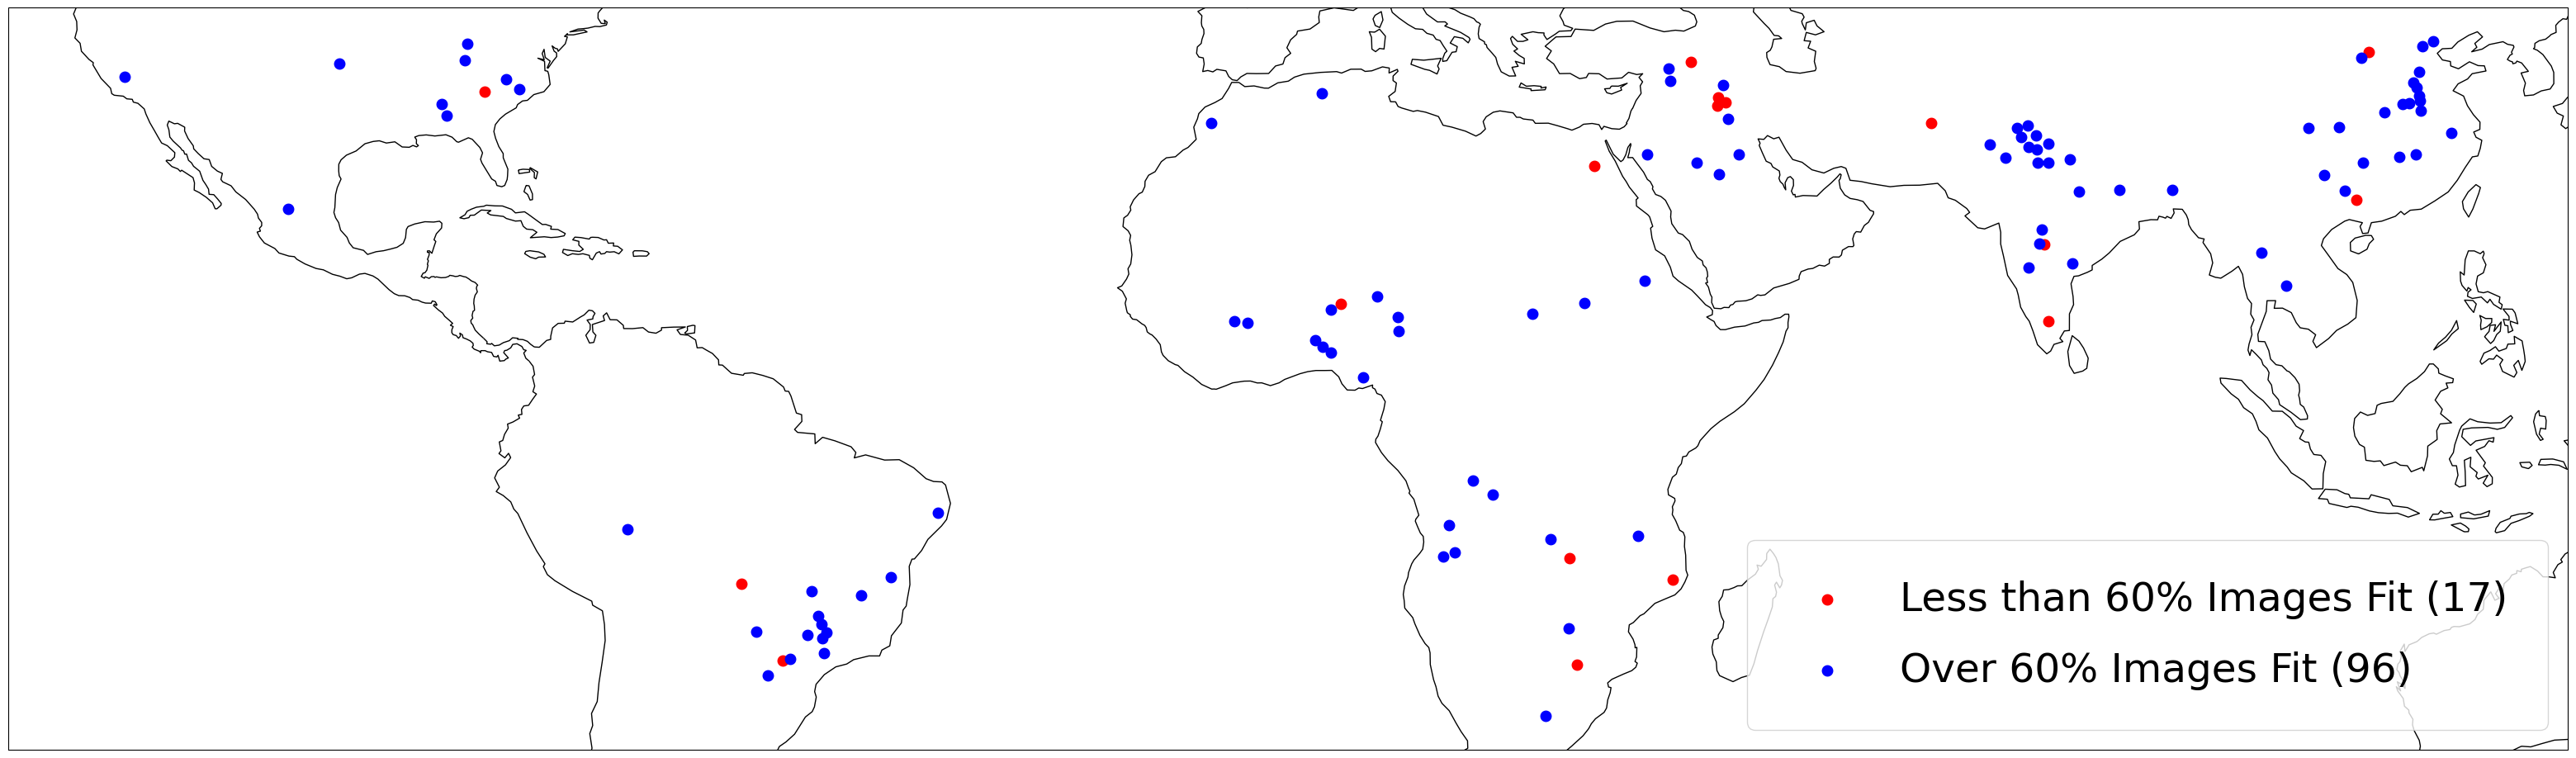

In [87]:
fig = plt.figure(figsize=(40,20))

remove = CITY_COUNTRY_lat_lon_remove

keep = CITY_COUNTRY_lat_lon_keep

remove_lats = remove['Lat']
remove_lons = remove['Lon']
remove_num_points = str(len(remove_lats))

keep_lats = keep['Lat']
keep_lons = keep['Lon']
keep_num_points = str(len(keep_lats))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ax.scatter(remove_lons, remove_lats, zorder=5,color='red', 
           label='Less than 60% Images Fit ({})'.format(remove_num_points), linewidths = 4.0)

ax.scatter(keep_lons, keep_lats, zorder=5,color='blue', 
           label='Over 60% Images Fit ({})'.format(keep_num_points), linewidths = 4.0)

ax.legend(loc=0, borderpad = 1, fontsize = 35, labelspacing=0.8)
#save 
os.chdir(os.path.join(et.io.HOME, 'Documents', 'UEA', 'Urban_Heat', 'PROJECT','City_Selection','Selection_Images'))
plt.savefig('gsa_fitting_60%.png')

In [68]:
qc_info_df

,corr < 0.5,rmse > 2.5,a0,x0,y0,phi,ax,ay,quantile_a0,num of no fits,total,CITY_COUNTRY,Lat,Lon
0,153,37,9,66,54,64,11,8,0,175,721,HUAMBO_ANGOLA,-12.776110,15.739170
1,160,74,0,94,54,24,1,0,0,208,664,ANAPOLIS_BRAZIL,-16.326670,-48.952780
2,327,89,0,76,51,11,0,0,0,376,626,CUIABA_BRAZIL,-15.596110,-56.096670
3,25,81,2,153,56,33,2,2,0,98,711,FRANCA_BRAZIL,-20.538610,-47.400830
4,319,169,2,52,57,35,2,2,0,399,752,MARINGA_BRAZIL,-23.425280,-51.938610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,98,48,1,46,66,17,1,1,0,131,760,LEXINGTON_FAYETTE_USA,38.029632,-84.494642
109,34,73,0,4,8,25,0,0,0,102,808,MONTGOMERY_USA,32.372034,-86.304457
110,64,38,3,60,113,32,3,3,0,98,829,VISALIA_USA,36.324100,-119.307347
111,238,27,3,66,64,20,3,3,0,250,821,WICHITA_USA,37.688848,-97.336226


In [35]:
#load in csv of city lons and lats
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))

CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx')  

In [36]:
CITY_COUNTRY_lat_lon

,CITY_COUNTRY,City,Lat,Lon,City_Area,City_Bound_xmin,City_Bound_xmax,City_Bound_ymin,City_Bound_ymax,koppen_climate,...,ell_theta_2018,eccen_2018,major_ax_2019,minor_ax_2019,ell_theta_2019,eccen_2019,major_ax_2020,minor_ax_2020,ell_theta_2020,eccen_2020
0,HUAMBO_ANGOLA,Huambo,-12.776110,15.739170,73,-6000,8000,-10000,6000,Cwb,...,1.145516,0.358135,4747.419568,5089.130083,0.787862,0.360253,4822.026302,5261.610509,1.047506,0.400139
1,ANAPOLIS_BRAZIL,Anapolis,-16.326670,-48.952780,92,-7000,10000,-10000,15000,Aw,...,0.163420,0.816725,4312.304087,7850.274955,0.203487,0.835613,4312.304087,7850.274955,0.203487,0.835613
2,CUIABA_BRAZIL,Cuiaba,-15.596110,-56.096670,201,-12000,18000,-12000,8000,Aw,...,1.725419,0.719885,7216.053842,10313.602288,1.758793,0.714472,7216.053842,10313.602288,1.758793,0.714472
3,FRANCA_BRAZIL,Franca,-20.538610,-47.400830,72,-8000,6000,-8000,8000,Cwa,...,-0.646858,0.608632,5507.885471,4440.010094,-0.701579,0.591754,5507.885471,4440.010094,-0.701579,0.591754
4,MARINGA_BRAZIL,Maringa,-23.425280,-51.938610,116,-14000,11000,-8000,9000,Cfa,...,1.707275,0.819770,4880.149526,8479.487194,1.717465,0.817785,4880.149526,8479.487194,1.717465,0.817785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,ALBUQUERQUE_UNITED_STATES,Albuquerque,35.110703,-106.609991,514,-18000,18000,-17000,20000,NaN,...,1.623845,0.556922,11861.068098,9862.316421,1.633631,0.555545,11861.068098,9862.316421,1.633631,0.555545
75,BOISE_CITY_UNITED_STATES,Boise City,43.619505,-116.212301,207,-20500,10000,-11000,15000,NaN,...,1.124562,0.749342,6445.342855,9698.656470,1.140043,0.747235,6445.342855,9698.656470,1.140043,0.747235
76,VICTORVILLE_HESPERIA_APPLE_VALLEY_UNITED_STATES,Victorville-Hesperia-Apple Valley,34.533991,-117.295848,190,-15000,15000,-20000,4000,NaN,...,1.351653,0.528667,7872.542074,9466.185445,1.369948,0.555302,7872.542074,9466.185445,1.369948,0.555302
77,ANDIZHAN_UZBEKISTAN,Andizhan,40.783056,72.343889,157,-8000,8000,-10000,11000,NaN,...,1.508274,0.580527,7420.227622,6038.486343,1.508079,0.581163,7420.227622,6038.486343,1.508079,0.581163


In [41]:
## Creating graphs again separately and table containing the qc info 

###############################################################
#################### CREATE PLOTS ONLY ########################
###############################################################
#Create graphs of the parameters and save them 

## MAKE SURE THE PLOT STYLE IS SET TO DEFAULT ##
plt.style.use('default')

#create lists for the quality checks 
day_corr_list = []
day_rmse_list = []
day_a0_std_list = []
day_x0_std_list = []
day_y0_std_list = []
day_phi_std_list = []
day_ax_std_list = []
day_ay_list = []
day_quantile_a0_list = []
day_num_no_fits_list = []
day_total_list = []

night_corr_list = []
night_rmse_list = []
night_a0_std_list = []
night_x0_std_list = []
night_y0_std_list = []
night_phi_std_list = []
night_ax_std_list = []
night_ay_list = []
night_quantile_a0_list = []
night_num_no_fits_list = []
night_total_list = []


#DAYTIME and NIGHTIME
satellite_name = 'Aqua'
SATELLITE = 'MYD11A2'
#set year span as different for terra and aqua
if satellite_name == 'Terra':
    year_span = range(2000,2021)
else:
    year_span = range(2002,2021)  

for i_count, CITY_COUNTRY in enumerate(CITY_COUNTRY_lat_lon.CITY_COUNTRY):
     #set path
    os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, SATELLITE))
    #read in monthly/ annual data pickles and all parameters before qc
    #day pickles
    pickle_name = 'monthly_day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'rb') as f:
        monthly_day_df = pickle.load(f)  
    
    pickle_name = 'annual_day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'rb') as f:
        annual_day_df = pickle.load(f)

    pickle_name = 'Parameters_Day_inital_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'rb') as f:
        parameters_df = pickle.load(f) 
    
    pickle_name = 'Parameters_Day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'rb') as f:
        parameters_df_qu = pickle.load(f) 
    
    #night pickles
    pickle_name = 'monthly_night_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'rb') as f:
        monthly_night_df = pickle.load(f)
    
    pickle_name = 'annual_night_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'rb') as f:
        annual_night_df = pickle.load(f)
    
    pickle_name = 'Parameters_Night_inital_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'rb') as f:
        parameters_night_df = pickle.load(f)
    
    pickle_name = 'Parameters_Night_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'rb') as f:
        parameters_night_df_qu = pickle.load(f)
    
    fig, axes = plt.subplots(nrows = 7,ncols = 2, figsize=(20, 35))

    if satellite_name == 'Terra':
        day_label = 'Day (10:30am)'
        night_label = 'Night (10:30pm)'
    else:
        day_label = 'Day (1:30pm)'
        night_label = 'Night (1.30am)'

    axes[0,0].plot(monthly_averages.day_a0, 'r', label = day_label)
    axes[0,0].plot(night_monthly_averages.night_a0, 'b', label = night_label)
    axes[0,0].set_title('{} Monthly SUHI Peak Magnitude {}'.format(City_name, satellite_name))
    axes[0,0].set(xlabel = 'Month', ylabel = 'SUHI magnitude (K)')
    axes[0,0].legend()

    axes[0,1].plot(yearly_averages.day_a0, 'r', label = day_label)
    axes[0,1].plot(night_yearly_averages.night_a0, 'b', label = night_label)
    axes[0,1].set_title('{} Annual SUHI Peak Magnitude {}'.format(City_name, satellite_name))
    axes[0,1].set(xlabel = 'Year', ylabel = 'SUHI magnitude (K)')
    axes[0,1].legend()

    axes[1,0].plot(monthly_averages.footprint_area, 'r', label = day_label)
    axes[1,0].plot(night_monthly_averages.footprint_area, 'b', label = night_label)
    axes[1,0].set_title('{} Monthly SUHI footprint {}'.format(City_name, satellite_name))
    axes[1,0].set(xlabel = 'Month', ylabel = 'Footprint area (km ^2)')
    axes[1,0].legend()

    axes[1,1].plot(yearly_averages.footprint_area, 'r', label = day_label)
    axes[1,1].plot(night_yearly_averages.footprint_area, 'b', label = night_label)
    axes[1,1].set_title('{} Annual  SUHI footprint {}'.format(City_name, satellite_name))
    axes[1,1].set(xlabel = 'Year', ylabel = 'Footprint area (km ^2)')
    axes[1,1].legend()

    axes[2,0].plot(monthly_averages.quantile_a0, 'r', label = day_label)
    axes[2,0].plot(night_monthly_averages.quantile_a0, 'b', label = night_label)
    axes[2,0].set_title('{} Monthly Peak Magnitude: Quantile Method {}'.format(City_name, satellite_name))
    axes[2,0].set(xlabel = 'Month', ylabel = 'SUHI magnitude (K)')
    axes[2,0].legend()

    axes[2,1].plot(yearly_averages.quantile_a0, 'r', label = day_label)
    axes[2,1].plot(night_yearly_averages.quantile_a0, 'b', label = night_label)
    axes[2,1].set_title('{} Annual Peak Magnitude: Quantile Method {}'.format(City_name, satellite_name))
    axes[2,1].set(xlabel = 'Year', ylabel = 'SUHI magnitude (K)')
    axes[2,1].legend()

    axes[3,0].plot(monthly_averages.method_2_SUHI, 'r', label = day_label)
    axes[3,0].plot(night_monthly_averages.method_2_SUHI, 'b', label = night_label)
    axes[3,0].set_title('{} Monthly Mean SUHI (method 2) {}'.format(City_name, satellite_name))
    axes[3,0].set(xlabel = 'Month', ylabel = 'SUHI magnitude (K)')
    axes[3,0].legend()

    axes[3,1].plot(yearly_averages.method_2_SUHI, 'r', label = day_label)
    axes[3,1].plot(night_yearly_averages.method_2_SUHI, 'b', label = night_label)
    axes[3,1].set_title('{} Annual Mean SUHI (method 2) {}'.format(City_name, satellite_name))
    axes[3,1].set(xlabel = 'Year', ylabel = 'SUHI magnitude (K)')
    axes[3,1].legend()

    axes[4,0].plot(monthly_averages.day_x0, 'r', label = day_label)
    axes[4,0].plot(night_monthly_averages.night_x0, 'b', label = night_label)
    axes[4,0].set_title('{} X distance from city centre {}'.format(City_name, satellite_name))
    axes[4,0].set(xlabel = 'Month', ylabel = 'x0')
    axes[4,0].legend()

    axes[4,1].plot(yearly_averages.day_x0, 'r', label = day_label)
    axes[4,1].plot(night_yearly_averages.night_x0, 'b', label = night_label)
    axes[4,1].set_title('{} X distance from city centre {}'.format(City_name, satellite_name))
    axes[4,1].set(xlabel = 'Year', ylabel = 'x0')
    axes[4,1].legend()

    axes[5,0].plot(monthly_averages.day_y0, 'r', label = day_label)
    axes[5,0].plot(night_monthly_averages.night_y0, 'b', label = night_label)
    axes[5,0].set_title('{} Y distance from city centre {}'.format(City_name, satellite_name))
    axes[5,0].set(xlabel = 'Month', ylabel = 'y0')
    axes[5,0].legend()

    axes[5,1].plot(yearly_averages.day_y0, 'r', label = day_label)
    axes[5,1].plot(night_yearly_averages.night_y0, 'b', label = night_label)
    axes[5,1].set_title('{} Y distance from city centre {}'.format(City_name, satellite_name))
    axes[5,1].set(xlabel = 'Year', ylabel = 'y0')
    axes[5,1].legend()

    axes[6,0].plot(monthly_averages.buffer_5km_SUHI, 'r', label = day_label)
    axes[6,0].plot(night_monthly_averages.buffer_5km_SUHI, 'b', label = night_label)
    axes[6,0].set_title('{} SUHI based on 5km buffer {}'.format(City_name, satellite_name))
    axes[6,0].set(xlabel = 'Month', ylabel = 'SUHI Magnitude')
    axes[6,0].legend()

    axes[6,1].plot(yearly_averages.buffer_5km_SUHI, 'r', label = day_label)
    axes[6,1].plot(night_yearly_averages.buffer_5km_SUHI, 'b', label = night_label)
    axes[6,1].set_title('{} SUHI based on 5km buffer {}'.format(City_name, satellite_name))
    axes[6,1].set(xlabel = 'Year', ylabel = 'SUHI Magnitude')
    axes[6,1].legend()

    xa = axes[0,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) #make sure the y axis sticks to integers as is by year
    xa = axes[1,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[2,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[3,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[4,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[5,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[6,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 

    #save the plot as a png
    plt.savefig('SUHI_trend_{}_{}.png'.format(City_name, satellite_name))
    plt.close()
    
    #create plots with std dev bars
    fig, axes = plt.subplots(nrows = 6,ncols = 2, figsize=(20, 30))

    axes[0,0].errorbar(x = range(1,13), y = monthly_averages.day_a0, yerr = monthly_std_dev.day_a0, color = 'b')
    axes[0,0].set_title('{} Monthly SUHI Peak Magnitude {} Day'.format(City_name, satellite_name))
    axes[0,0].set(xlabel = 'Month', ylabel = 'SUHI magnitude (K)')

    axes[0,1].errorbar(x = year_span, y = yearly_averages.day_a0, yerr = yearly_std_dev.day_a0, color = 'b')
    axes[0,1].set_title('{} Annual SUHI Peak Magnitude {} Day'.format(City_name, satellite_name))
    axes[0,1].set(xlabel = 'Year', ylabel = 'SUHI magnitude (K)')

    axes[1,0].errorbar(x = range(1,13), y = monthly_averages.footprint_area, yerr = monthly_std_dev.footprint_area, color = 'r')
    axes[1,0].set_title('{} Monthly SUHI footprint {} Day'.format(City_name, satellite_name))
    axes[1,0].set(xlabel = 'Month', ylabel = 'Footprint area (km ^2)')

    axes[1,1].errorbar(x = year_span, y = yearly_averages.footprint_area, yerr = yearly_std_dev.footprint_area, color = 'r')
    axes[1,1].set_title('{} Annual  SUHI footprint {} Day'.format(City_name, satellite_name))
    axes[1,1].set(xlabel = 'Year', ylabel = 'Footprint area (km ^2)')

    axes[2,0].errorbar(x = range(1,13), y = monthly_averages.quantile_a0, yerr = monthly_std_dev.quantile_a0, color = 'k')
    axes[2,0].set_title('{} Monthly Peak Magnitude: Quantile Method {} Day'.format(City_name, satellite_name))
    axes[2,0].set(xlabel = 'Month', ylabel = 'SUHI magnitude (K)')

    axes[2,1].errorbar(x = year_span, y = yearly_averages.quantile_a0, yerr = yearly_std_dev.quantile_a0, color = 'k')
    axes[2,1].set_title('{} Annual Peak Magnitude: Quantile Method {} Day'.format(City_name, satellite_name))
    axes[2,1].set(xlabel = 'Year', ylabel = 'SUHI magnitude (K)')

    axes[3,0].errorbar(x = range(1,13), y = monthly_averages.method_2_SUHI, yerr = monthly_std_dev.method_2_SUHI, color = 'g')
    axes[3,0].set_title('{} Monthly Mean SUHI (method 2) {} Day'.format(City_name, satellite_name))
    axes[3,0].set(xlabel = 'Month', ylabel = 'SUHI magnitude (K)')

    axes[3,1].errorbar(x = year_span, y = yearly_averages.method_2_SUHI, yerr = yearly_std_dev.method_2_SUHI, color = 'g')
    axes[3,1].set_title('{} Annual Mean SUHI (method 2) {} Day'.format(City_name, satellite_name))
    axes[3,1].set(xlabel = 'Year', ylabel = 'SUHI magnitude (K)')

    axes[4,0].errorbar(x = range(1,13), y = monthly_averages.day_x0, yerr = monthly_std_dev.day_x0, color = 'm')
    axes[4,0].set_title('{} X distance from city centre {} Day'.format(City_name, satellite_name))
    axes[4,0].set(xlabel = 'Month', ylabel = 'x0')

    axes[4,1].errorbar(x = year_span, y = yearly_averages.day_x0, yerr = yearly_std_dev.day_x0, color = 'm')
    axes[4,1].set_title('{} X distance from city centre {} Day'.format(City_name, satellite_name))
    axes[4,1].set(xlabel = 'Year', ylabel = 'x0')

    axes[5,0].errorbar(x = range(1,13), y = monthly_averages.day_y0, yerr = monthly_std_dev.day_y0, color = 'c')
    axes[5,0].set_title('{} Y distance from city centre {} Day'.format(City_name, satellite_name))
    axes[5,0].set(xlabel = 'Month', ylabel = 'y0')

    axes[5,1].errorbar(x = year_span, y = yearly_averages.day_y0, yerr = yearly_std_dev.day_y0, color = 'c')
    axes[5,1].set_title('{} Y distance from city centre {} Day'.format(City_name, satellite_name))
    axes[5,1].set(xlabel = 'Year', ylabel = 'y0')

    xa = axes[0,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) #make sure the y axis sticks to integers as is by year
    xa = axes[1,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[2,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[3,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[4,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[5,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 

    #save the plot as a png
    plt.savefig('SUHI_trend_{}_{}_day_error_bars.png'.format(City_name, satellite_name))
    plt.close()
    
    #nighttime
    #create plots with std dev bars
    fig, axes = plt.subplots(nrows = 6,ncols = 2, figsize=(20, 30))

    axes[0,0].errorbar(x = range(1,13), y = night_monthly_averages.night_a0, yerr = night_monthly_std_dev.night_a0, color = 'b')
    axes[0,0].set_title('{} Monthly SUHI Peak Magnitude {} Night'.format(City_name, satellite_name))
    axes[0,0].set(xlabel = 'Month', ylabel = 'SUHI magnitude (K)')

    axes[0,1].errorbar(x = year_span, y = night_yearly_averages.night_a0, yerr = night_yearly_std_dev.night_a0, color = 'b')
    axes[0,1].set_title('{} Annual SUHI Peak Magnitude {} Night'.format(City_name, satellite_name))
    axes[0,1].set(xlabel = 'Year', ylabel = 'SUHI magnitude (K)')

    axes[1,0].errorbar(x = range(1,13), y = night_monthly_averages.footprint_area, yerr = night_monthly_std_dev.footprint_area, color = 'r')
    axes[1,0].set_title('{} Monthly SUHI footprint {} Night'.format(City_name, satellite_name))
    axes[1,0].set(xlabel = 'Month', ylabel = 'Footprint area (km ^2)')

    axes[1,1].errorbar(x = year_span, y = night_yearly_averages.footprint_area, yerr = night_yearly_std_dev.footprint_area, color = 'r')
    axes[1,1].set_title('{} Annual  SUHI footprint {} Night'.format(City_name, satellite_name))
    axes[1,1].set(xlabel = 'Year', ylabel = 'Footprint area (km ^2)')

    axes[2,0].errorbar(x = range(1,13), y = night_monthly_averages.quantile_a0, yerr = night_monthly_std_dev.quantile_a0, color = 'k')
    axes[2,0].set_title('{} Monthly Peak Magnitude: Quantile Method {} Night'.format(City_name, satellite_name))
    axes[2,0].set(xlabel = 'Month', ylabel = 'SUHI magnitude (K)')

    axes[2,1].errorbar(x = year_span, y = night_yearly_averages.quantile_a0, yerr = night_yearly_std_dev.quantile_a0, color = 'k')
    axes[2,1].set_title('{} Annual Peak Magnitude: Quantile Method {} Night'.format(City_name, satellite_name))
    axes[2,1].set(xlabel = 'Year', ylabel = 'SUHI magnitude (K)')

    axes[3,0].errorbar(x = range(1,13), y = night_monthly_averages.method_2_SUHI, yerr = night_monthly_std_dev.method_2_SUHI, color = 'g')
    axes[3,0].set_title('{} Monthly Mean SUHI (method 2) {} Night'.format(City_name, satellite_name))
    axes[3,0].set(xlabel = 'Month', ylabel = 'SUHI magnitude (K)')

    axes[3,1].errorbar(x = year_span, y = night_yearly_averages.method_2_SUHI, yerr = night_yearly_std_dev.method_2_SUHI, color = 'g')
    axes[3,1].set_title('{} Annual Mean SUHI (method 2) {} Night'.format(City_name, satellite_name))
    axes[3,1].set(xlabel = 'Year', ylabel = 'SUHI magnitude (K)')

    axes[4,0].errorbar(x = range(1,13), y = night_monthly_averages.night_x0, yerr = night_monthly_std_dev.night_x0, color = 'm')
    axes[4,0].set_title('{} X distance from city centre {} Night'.format(City_name, satellite_name))
    axes[4,0].set(xlabel = 'Month', ylabel = 'x0')

    axes[4,1].errorbar(x = year_span, y = night_yearly_averages.night_x0, yerr = night_yearly_std_dev.night_x0, color = 'm')
    axes[4,1].set_title('{} X distance from city centre {} Night'.format(City_name, satellite_name))
    axes[4,1].set(xlabel = 'Year', ylabel = 'x0')

    axes[5,0].errorbar(x = range(1,13), y = night_monthly_averages.night_y0, yerr = night_monthly_std_dev.night_y0, color = 'c')
    axes[5,0].set_title('{} Y distance from city centre {} Night'.format(City_name, satellite_name))
    axes[5,0].set(xlabel = 'Month', ylabel = 'y0')

    axes[5,1].errorbar(x = year_span, y = night_yearly_averages.night_y0, yerr = night_yearly_std_dev.night_y0, color = 'c')
    axes[5,1].set_title('{} Y distance from city centre {} Night'.format(City_name, satellite_name))
    axes[5,1].set(xlabel = 'Year', ylabel = 'y0')

    xa = axes[0,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) #make sure the y axis sticks to integers as is by year
    xa = axes[1,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[2,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[3,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[4,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 
    xa = axes[5,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) 

    #save the plot as a png
    plt.savefig('SUHI_trend_{}_{}_night_error_bars.png'.format(City_name, satellite_name))
    plt.close()
    
    
    # Generate the quality check
    
    # Day 
    #number of images with corr < 0.5 
    day_corr_list.append(len(parameters_df[parameters_df['corr'] < 0.5].index))

    #number with rmse > 2.5
    day_rmse_list.append(len(parameters_df[parameters_df['rmse'] > 2.5].index))


    #Number of images with parameter standard deviation higher than mean
    day_a0_std_list.append(len(parameters_df[abs(parameters_df['day_std_dev_a0'] / parameters_df['day_a0']) > 1].index))

    day_x0_std_list.append(len(parameters_df[abs(parameters_df['day_std_dev_x0'] / parameters_df['day_x0']) > 1].index))

    day_y0_std_list.append(len(parameters_df[abs(parameters_df['day_std_dev_y0'] / parameters_df['day_y0']) > 1].index))

    day_phi_std_list.append(len(parameters_df[abs(parameters_df['day_std_dev_phi'] / parameters_df['day_phi']) > 1].index))

    day_ax_std_list.append(len(parameters_df[abs(parameters_df['day_std_dev_ax'] / parameters_df['day_ax']) > 1].index))

    day_ay_list.append(len(parameters_df[abs(parameters_df['day_std_dev_ay'] / parameters_df['day_ay']) > 1].index))

    day_quantile_a0_list.append(len(parameters_df[np.isnan(parameters_df["quantile_a0"])].index))

    day_num_no_fits_list.append(len(parameters_df_qu[np.isnan(parameters_df_qu['day_a0'])]))

    day_total_list.append(len(parameters_df))
    
    # Night
    #number of images with corr < 0.5 
    night_corr_list.append(len(parameters_night_df[parameters_night_df['corr'] < 0.5].index))

    #number with rmse > 2.5
    night_rmse_list.append(len(parameters_night_df[parameters_night_df['rmse'] > 2.5].index))

    #Number of images with parameter standard deviation higher than mean
    night_a0_std_list.append(len(parameters_night_df[abs(parameters_night_df['night_std_dev_a0']/parameters_night_df['night_a0']) > 1].index))

    night_x0_std_list.append(len(parameters_night_df[abs(parameters_night_df['night_std_dev_x0']/parameters_night_df['night_x0']) > 1].index))

    night_y0_std_list.append(len(parameters_night_df[abs(parameters_night_df['night_std_dev_y0']/parameters_night_df['night_y0']) > 1].index))

    night_phi_std_list.append(len(parameters_night_df[abs(parameters_night_df['night_std_dev_phi']/parameters_night_df['night_phi']) > 1].index))

    night_ax_std_list.append(len(parameters_night_df[abs(parameters_night_df['night_std_dev_ax']/parameters_night_df['night_ax']) > 1].index))

    night_ay_list.append(len(parameters_night_df[abs(parameters_night_df['night_std_dev_ay']/parameters_night_df['night_ay']) > 1].index))

    night_quantile_a0_list.append(len(parameters_night_df[np.isnan(parameters_night_df["quantile_a0"])].index))

    night_num_no_fits_list.append(len(parameters_night_df_qu[np.isnan(parameters_night_df_qu['night_a0'])]))

    night_total_list.append(len(parameters_night_df))
    
    
#send the qc data to a df and save
#DAYTIME
country_list = CITY_COUNTRY_lat_lon.CITY_COUNTRY.values.tolist()
contents = [country_list, day_corr_list, day_rmse_list, day_a0_std_list, day_x0_std_list,day_y0_std_list,day_phi_std_list, 
            day_ax_std_list,day_ay_list,day_quantile_a0_list, day_num_no_fits_list, day_total_list ]
qc_info_df = pd.DataFrame(contents).transpose()
qc_info_df.columns = ['CITY_COUNTRY','corr < 0.5','rmse > 2.5','a0','x0','y0','phi','ax','ay','quantile_a0',
                      'num of no fits','total']
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
with open('GSA_day_qc_info.pkl', 'wb') as f:
    pickle.dump(qc_info_df, f)

    
#NIGHT TIME
contents = [country_list, night_corr_list, night_rmse_list, night_a0_std_list, night_x0_std_list,night_y0_std_list,
            night_phi_std_list, night_ax_std_list, night_ay_list, night_quantile_a0_list, night_num_no_fits_list, 
            night_total_list ]
qc_info_df = pd.DataFrame(contents).transpose()
qc_info_df.columns = ['CITY_COUNTRY','corr < 0.5','rmse > 2.5','a0','x0','y0','phi','ax','ay','quantile_a0',
                      'num of no fits','total']
with open('GSA_night_qc_info.pkl', 'wb') as f:
    pickle.dump(qc_info_df, f)   



In [46]:
# how many images being bad quality should make the city not be used?
with open('GSA_day_qc_info.pkl', 'rb') as f:
    day_qc_info_df = pickle.load(f) 
    
with open('GSA_night_qc_info.pkl', 'rb') as f:
    night_qc_info_df = pickle.load(f)   
    
day_qc_info_df['perc_bad_quality'] = day_qc_info_df['num of no fits']/ day_qc_info_df['total']

In [63]:
day_qc_info_df[day_qc_info_df['CITY_COUNTRY'] == 'WUHAI_CHINA']

,CITY_COUNTRY,corr < 0.5,rmse > 2.5,a0,x0,y0,phi,ax,ay,quantile_a0,num of no fits,total,perc_bad_quality
55,WUHAI_CHINA,156,371,14,35,38,29,14,15,0,430,904,0.475664


In [83]:
day_qc_info_df[day_qc_info_df['perc_bad_quality'] > 0.4].CITY_COUNTRY.values

array(['CUIABA_BRAZIL', 'MARINGA_BRAZIL', 'NDOLA_ZAMBIA',
       'NAMPULA_MOZAMBIQUE', 'SOKOTO_NIGERIA', 'SHIZUISHAN_CHINA',
       'WUHAI_CHINA', 'XINZHOU_CHINA', 'ZHANGYE_CHINA',
       'TARAZ_KAZAKHSTAN', 'BLANTYRE_LIMBE_MALAWI', 'CHIHUAHUA_MEXICO',
       'ALBUQUERQUE_UNITED_STATES', 'BOISE_CITY_UNITED_STATES',
       'VICTORVILLE_HESPERIA_APPLE_VALLEY_UNITED_STATES',
       'ANDIZHAN_UZBEKISTAN'], dtype=object)

In [82]:
len(day_qc_info_df[day_qc_info_df['perc_bad_quality'] > 0.4].CITY_COUNTRY.values)

16

In [29]:
# remove the image from the dataset which have too many contaminated urban pixels (doing this now but if run again they have 
# been removed from the QC lists already)

for count, CITY_COUNTRY in enumerate(CITY_COUNTRY_lat_lon.CITY_COUNTRY):

    os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, SATELLITE))

    with open('removed_day.pkl', 'rb') as f:
        removed_day = pickle.load(f)
    
    with open('removed_night.pkl', 'rb') as f:
        removed_night = pickle.load(f)

    #parameters
    pickle_name = 'Parameters_Day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'rb') as f:
        parameters_df = pickle.load(f)
    pickle_name = 'Parameters_Night_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'rb') as f:
        parameters_night_df = pickle.load(f)
    
    #removed the bad quality results
    parameters_df_new = parameters_df[~(parameters_df.Filename).isin(removed_day)].reset_index(drop = True)
    parameters_night_df_new = parameters_night_df[~(parameters_night_df.Filename).isin(removed_night)].reset_index(drop = True)

    #save the new parameters datasets
    pickle_name = 'Parameters_Day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'wb') as f:
        pickle.dump(parameters_df_new, f)

    pickle_name = 'Parameters_Night_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'wb') as f:
        pickle.dump(parameters_night_df_new, f)
    

In [55]:
CITY_COUNTRY = 'WUHAI_CHINA'
SATELLITE = 'MYD11A2' 


os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, SATELLITE))
pickle_name = 'Parameters_Day_inital_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
with open(pickle_name, 'rb') as f:
    parameters_df = pickle.load(f) 
    
pickle_name = 'Parameters_Day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
with open(pickle_name, 'rb') as f:
    parameters_df_qu = pickle.load(f) 

Code below is for viewing individual images given the file name 

In [54]:
#function to open the file and get temps into required format
def image_gen(choose_file):
    df_subset = dataframe_create(choose_file, city_top = False)
    yeardoy = choose_file.split('.')[1][1:]                               # Split filename to retrieve acquisition date
    date = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%d/%m/%Y') 
    year = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%Y') 
    month = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%m') 

    #add in the x y coords
    df_subset['x_points'] = x_points
    df_subset['y_points'] = y_points

    #add a translated QC flag (where 0 is usuable, 1 not usable) 
    #apply QC function to dataframe (function checks that the first 2 bytes of the QC flag are 0, which means its good quality)
    QC_day2 = np.array([quality_control(int(i)) for i in df_subset.QC_day])
    #QC_night2 = np.array([quality_control(int(i)) for i in df_subset.QC_night])

    #add this QC2 flag onto the dataset
    df_subset['QC_day2'] = QC_day2
    #df_subset['QC_night2'] = QC_night2

    #add in the urban classification
    #going to remove 2021 anyway so doesn't matter its not accurate
    if year in ('2021'):
        year2 = '2020'
    else:
        year2 = year
    #add in urban classification to check for urban land    
    df_subset['is_urban'] = LULC_df['is_urban_overall_{}'.format(year2)].values
    
    
    #outside of city area and urban
    df_drop = df_subset[((df_subset['x_points'] < City_bound_xmin) | (df_subset['x_points'] > City_bound_xmax) 
                             | (df_subset['y_points'] < City_bound_ymin) | (df_subset['y_points'] > City_bound_ymax)
              ) & (df_subset['is_urban'] == 1)]

    #remove the areas which are urban but outside the city from the analysis
    df_subset_2 = df_subset.drop(df_drop.index)
    
     #add in the nan flag so know which values cannot be used
    
    #if want to remove outside city urban areas
    #df_subset.loc[((df_subset['x_points'] < City_bound_xmin) | (df_subset['x_points'] > City_bound_xmax) 
    #                         | (df_subset['y_points'] < City_bound_ymin) | (df_subset['y_points'] > City_bound_ymax)
    #          ) & (df_subset['is_urban'] == 1), 'nan_flag'] = 1

    df_subset.loc[(df_subset['QC_day2'] != 0), 'nan_flag'] = 1
    
    #the urban classification and QC2 flag used to apply mask to the urban areas and the areas with QC2 flag = 1
    #remove the pixels which are not of good quality from the dataset
    #Separates into daytime good quality pixels and nightime good quality pixels 
    df_day_gq = df_subset_2[df_subset_2['QC_day2'] == 0].copy()
    
    df_rural_day = df_day_gq[df_day_gq['is_urban'] == 0][['LST_day','x_points', 'y_points']].copy()
    
    #will then apply a mulitple linear regression (with 2 variables, x and y) to this subset to get something of the form
    # LST = T0 + (a1)x + (a2)y
    #T0, a1, a2 coefficients to be determined

    #Perform regression
    #Divide the data into attributes and labels
    #rural daytime
    X = df_rural_day[['x_points','y_points']].values
    y = df_rural_day['LST_day'].values

    #Fit the model to the training set
    regressor = LinearRegression()
    regressor.fit(X, y)

    #Use the regression to predict T_0
    #This will give a baseline for what the temperature would be in the urban area if it was rural

    #create the column T_0 with the predicted rural baseline temperatures
    pred_input = df_subset[['x_points','y_points']].values
    df_subset['T_0_pred'] = regressor.predict(pred_input)

    #Take the predicted baseline temperature away from the LST to get the SUHI footprint 
    df_subset['SUHI'] = df_subset['LST_day'] - df_subset['T_0_pred']
    
     #update the predicted SUHI to have nans if the pixel is not valid
    df_subset.loc[(df_subset['nan_flag'] == 1), 'SUHI'] = np.nan
   
    return df_subset

In [11]:
#NIGHTIME
#function to open the file and get temps into required format
def image_gen_night(choose_file):
    df_subset = dataframe_create(choose_file, city_top = False)
    yeardoy = choose_file.split('.')[1][1:]                               # Split filename to retrieve acquisition date
    date = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%d/%m/%Y') 
    year = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%Y') 
    month = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%m') 

    #add in the x y coords
    df_subset['x_points'] = x_points
    df_subset['y_points'] = y_points

    #add a translated QC flag (where 0 is usuable, 1 not usable) 
    #apply QC function to dataframe (function checks that the first 2 bytes of the QC flag are 0, which means its good quality)
    QC_night2 = np.array([quality_control(int(i)) for i in df_subset.QC_night])

    #add this QC2 flag onto the dataset
    df_subset['QC_night2'] = QC_night2

    #add in the urban classification
    #going to remove 2021 anyway so doesn't matter its not accurate
    if year in ('2021'):
        year2 = '2020'
    else:
        year2 = year
    #add in urban classification to check for urban land    
    df_subset['is_urban'] = LULC_df['is_urban_overall_{}'.format(year2)].values
    
    
    #outside of city area and urban
    df_drop = df_subset[((df_subset['x_points'] < City_bound_xmin) | (df_subset['x_points'] > City_bound_xmax) 
                             | (df_subset['y_points'] < City_bound_ymin) | (df_subset['y_points'] > City_bound_ymax)
              ) & (df_subset['is_urban'] == 1)]

    #remove the areas which are urban but outside the city from the analysis
    df_subset_2 = df_subset.drop(df_drop.index)
    
    #add in the nan flag so know which values cannot be used
    
    #if want to remove outside city urban areas
    #df_subset.loc[((df_subset['x_points'] < City_bound_xmin) | (df_subset['x_points'] > City_bound_xmax) 
    #                         | (df_subset['y_points'] < City_bound_ymin) | (df_subset['y_points'] > City_bound_ymax)
    #          ) & (df_subset['is_urban'] == 1), 'nan_flag'] = 1

    df_subset.loc[(df_subset['QC_night2'] != 0), 'nan_flag'] = 1
   
    
    #the urban classification and QC2 flag used to apply mask to the urban areas and the areas with QC2 flag = 1
    #remove the pixels which are not of good quality from the dataset
    #Separates into daytime good quality pixels and nightime good quality pixels 
    df_night_gq = df_subset_2[df_subset_2['QC_night2'] == 0].copy()
    
    df_rural_night = df_night_gq[df_night_gq['is_urban'] == 0][['LST_night','x_points', 'y_points']].copy()
    
    #will then apply a mulitple linear regression (with 2 variables, x and y) to this subset to get something of the form
    # LST = T0 + (a1)x + (a2)y
    #T0, a1, a2 coefficients to be determined

    #Perform regression
    #Divide the data into attributes and labels
    #rural daytime
    X = df_rural_night[['x_points','y_points']].values
    y = df_rural_night['LST_night'].values

    #Fit the model to the training set
    regressor = LinearRegression()
    regressor.fit(X, y)

    #Use the regression to predict T_0
    #This will give a baseline for what the temperature would be in the urban area if it was rural

    #create the column T_0 with the predicted rural baseline temperatures
    pred_input = df_subset[['x_points','y_points']].values
    df_subset['T_0_pred'] = regressor.predict(pred_input)

    #Take the predicted baseline temperature away from the LST to get the SUHI footprint 
    df_subset['SUHI'] = df_subset['LST_night'] - df_subset['T_0_pred']
    
     #update the predicted SUHI to have nans if the pixel is not valid
    df_subset.loc[(df_subset['nan_flag'] == 1), 'SUHI'] = np.nan
   
    return df_subset

In [59]:
parameters_df_qu[np.isnan(parameters_df_qu['day_a0'])]

,Filename,Date,Year,Month,day_a0,day_x0,day_y0,day_phi,day_ax,day_ay,...,corr,rmse,method_1_SUHI,method_2_SUHI,buffer_5km_SUHI,quantile_a0,quantile_75,city_pixels_used,rural_corr,eccentricity
0,MYD11A2.A2002185.h26v05.006.2015146152712.hdf,04/07/2002,2002,07,NaN,NaN,NaN,NaN,NaN,NaN,...,0.612481,3.088434,1.363946,1.165552,2.386886,5.850,3.405,276.0,0.705454,0.893004
1,MYD11A2.A2002193.h26v05.006.2015146153053.hdf,12/07/2002,2002,07,NaN,NaN,NaN,NaN,NaN,NaN,...,0.683109,3.054287,2.610684,2.332516,3.824221,6.750,3.325,276.0,0.747461,0.822346
2,MYD11A2.A2002201.h26v05.006.2015146153311.hdf,20/07/2002,2002,07,NaN,NaN,NaN,NaN,NaN,NaN,...,0.658039,3.247010,-0.054279,-0.356532,0.943400,-6.445,-3.490,276.0,0.741928,0.780341
3,MYD11A2.A2002209.h26v05.006.2015152152811.hdf,28/07/2002,2002,07,NaN,NaN,NaN,NaN,NaN,NaN,...,0.357752,5.462301,2.482355,1.921838,1.497671,10.289,5.975,268.0,0.568618,0.842737
4,MYD11A2.A2002217.h26v05.006.2015149014151.hdf,05/08/2002,2002,08,NaN,NaN,NaN,NaN,NaN,NaN,...,0.400867,3.253232,0.170797,-0.166978,1.145575,-4.675,-2.150,276.0,0.762401,0.873871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899,MYD11A2.A2022129.h26v05.006.2022141163005.hdf,09/05/2022,2022,05,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550976,3.779208,-1.613898,-1.887815,0.456284,-6.785,-3.450,276.0,0.686228,NaN
900,MYD11A2.A2022137.h26v05.006.2022146043651.hdf,17/05/2022,2022,05,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.042591,4.763093,-2.829162,-3.156400,-0.396190,-6.980,-3.955,276.0,0.669722,0.903101
901,MYD11A2.A2022145.h26v05.006.2022154064507.hdf,25/05/2022,2022,05,NaN,NaN,NaN,NaN,NaN,NaN,...,0.535295,2.976506,-1.618402,-1.958190,0.552814,-5.065,-2.440,276.0,0.727910,0.521437
902,MYD11A2.A2022153.h26v05.006.2022162061306.hdf,02/06/2022,2022,06,NaN,NaN,NaN,NaN,NaN,NaN,...,0.504041,3.600627,-1.071645,-1.550902,1.187576,-6.740,-3.230,276.0,0.741645,0.551902


In [60]:
parameters_df[np.isnan(parameters_df_qu['day_a0'])]

,Filename,Date,Year,Month,day_a0,day_x0,day_y0,day_phi,day_ax,day_ay,...,corr,rmse,method_1_SUHI,method_2_SUHI,buffer_5km_SUHI,quantile_a0,quantile_75,city_pixels_used,rural_corr,eccentricity
0,MYD11A2.A2002185.h26v05.006.2015146152712.hdf,04/07/2002,2002,07,5.740714,4.622625,2.080404,8.157059,3.593805,19.320508,...,0.612481,3.088434,1.363946,1.165552,2.386886,5.850,3.405,276.0,0.705454,0.893004
1,MYD11A2.A2002193.h26v05.006.2015146153053.hdf,12/07/2002,2002,07,7.861240,3.413927,6.000000,99.393219,19.320508,3.960903,...,0.683109,3.054287,2.610684,2.332516,3.824221,6.750,3.325,276.0,0.747461,0.822346
2,MYD11A2.A2002201.h26v05.006.2015146153311.hdf,20/07/2002,2002,07,6.037659,3.752124,6.000000,8.457848,3.984760,14.135914,...,0.658039,3.247010,-0.054279,-0.356532,0.943400,-6.445,-3.490,276.0,0.741928,0.780341
3,MYD11A2.A2002209.h26v05.006.2015152152811.hdf,28/07/2002,2002,07,9.922360,3.229954,6.000000,3.617632,5.085032,19.320508,...,0.357752,5.462301,2.482355,1.921838,1.497671,10.289,5.975,268.0,0.568618,0.842737
4,MYD11A2.A2002217.h26v05.006.2015149014151.hdf,05/08/2002,2002,08,-6.825972,-2.400000,4.936662,-72.646771,19.319410,3.388706,...,0.400867,3.253232,0.170797,-0.166978,1.145575,-4.675,-2.150,276.0,0.762401,0.873871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899,MYD11A2.A2022129.h26v05.006.2022141163005.hdf,09/05/2022,2022,05,-7.934332,-2.400000,-2.124419,-151.226797,13.735590,-6.646945,...,0.550976,3.779208,-1.613898,-1.887815,0.456284,-6.785,-3.450,276.0,0.686228,NaN
900,MYD11A2.A2022137.h26v05.006.2022146043651.hdf,17/05/2022,2022,05,0.052957,1.926088,-0.827115,-0.000043,-0.048982,0.277974,...,-0.042591,4.763093,-2.829162,-3.156400,-0.396190,-6.980,-3.955,276.0,0.669722,0.903101
901,MYD11A2.A2022145.h26v05.006.2022154064507.hdf,25/05/2022,2022,05,4.266142,5.625287,-4.800000,-170.888156,-2.867827,19.320508,...,0.535295,2.976506,-1.618402,-1.958190,0.552814,-5.065,-2.440,276.0,0.727910,0.521437
902,MYD11A2.A2022153.h26v05.006.2022162061306.hdf,02/06/2022,2022,06,5.930951,5.756025,-4.800000,-80.014638,19.320508,3.140197,...,0.504041,3.600627,-1.071645,-1.550902,1.187576,-6.740,-3.230,276.0,0.741645,0.551902


In [27]:
choose_file = 'MYD11A2.A2002217.h21v06.006.2015149013901.hdf'

#temp_df = image_gen(choose_file)
temp_df = dataframe_create(choose_file, city_top = False)

In [28]:
temp_df

,LST_day,LST_night,QC_day,QC_night,Longitude,Latitude
559112,332.98,296.38,0,0,43.742208,26.121768
559113,333.00,296.40,0,0,43.751498,26.121768
559114,332.64,296.30,0,0,43.760787,26.121768
559115,332.44,296.20,0,0,43.770076,26.121768
559116,332.28,296.18,0,0,43.779365,26.121768
...,...,...,...,...,...,...
500341,332.98,297.96,0,0,44.167194,26.530442
500342,332.90,297.60,0,0,44.176516,26.530442
500343,332.96,297.24,0,0,44.185838,26.530442
500344,332.98,297.00,0,0,44.195160,26.530442


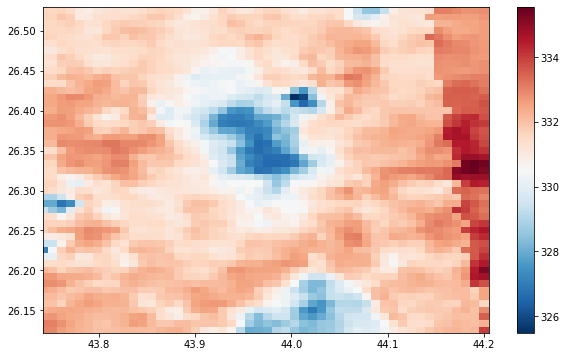

In [29]:
#Day
fig = plt.figure(figsize=(10, 6))
ax=plt.gca()

x_suhi = temp_df.Longitude
y_suhi = temp_df.Latitude
SUHI = temp_df.LST_day

#get the points into the correct format
X_suhi ,Y_suhi = np.meshgrid(x_suhi ,y_suhi)
Z_suhi = scipy.interpolate.griddata((x_suhi, y_suhi), SUHI, (X_suhi,Y_suhi), method='nearest')

c = ax.pcolormesh(X_suhi,Y_suhi, Z_suhi, cmap ='RdBu_r')
fig.colorbar(c, ax=ax)

Text(0.5, 1.0, 'SUHI (K), Al_Gadarif, 10.30, 19/07/2016')

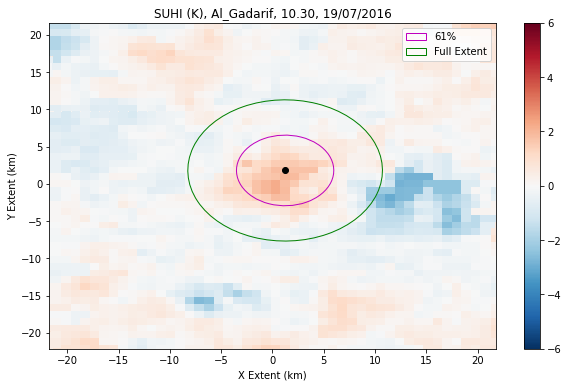

In [49]:
#Make plot with parameters on 
#Colour mesh plot
parameters_day = terra_parameters_day

a0 = parameters_day[parameters_day['Filename'] == choose_file]['day_a0'].values[0]
phi = parameters_day[parameters_day['Filename'] == choose_file]['day_phi'].values[0]

sphi2 = (np.sin(phi))**2
cphi2 = (np.cos(phi))**2
a_x = parameters_day[parameters_day['Filename'] == choose_file]['day_ax'].values[0]
a_y = parameters_day[parameters_day['Filename'] == choose_file]['day_ay'].values[0]
ax2 = a_x **2
ay2 = a_y **2
y0 = parameters_day[parameters_day['Filename'] == choose_file]['day_y0'].values[0]
x0 = parameters_day[parameters_day['Filename'] == choose_file]['day_x0'].values[0]

date = parameters_day[parameters_day['Filename'] == choose_file]['Date'].values[0]
#Function calculates x and y for a given SUHI magnitude
def calc_xy(SUHI):
    yextent = np.sqrt(np.log(SUHI/a0)/(-sphi2/(0.5*ax2)-cphi2/(0.5*ay2))) # yextent is y - y0
    xextent = np.sqrt(np.log(SUHI/a0)/(-cphi2/(0.5*ax2)-sphi2/(0.5*ay2))) # xextent is x- x0
    return [xextent,yextent]

#calculating where the temperature falls within 61% of its maximum value
xextent_61 = np.sqrt(1/(4*(cphi2/ax2 + sphi2/ay2))) # xextent is x - x0 #SUHI/a0 = e**-0.5
yextent_61 = np.sqrt(1/(4*(sphi2/ax2 + cphi2/ay2))) # yextent is y - y0 #SUHI/a0 = e**-0.5

fig = plt.figure(figsize=(10, 6))
ax=plt.gca()

x_suhi = temp_df.x_points
y_suhi = temp_df.y_points
SUHI = temp_df.SUHI

#get the points into the correct format
X_suhi ,Y_suhi = np.meshgrid(x_suhi ,y_suhi)
Z_suhi = scipy.interpolate.griddata((x_suhi, y_suhi), SUHI, (X_suhi,Y_suhi), method='nearest')

c = ax.pcolormesh(X_suhi,Y_suhi, Z_suhi, cmap ='RdBu_r', vmin=-6, vmax=6)
fig.colorbar(c, ax=ax)

ax.plot(x0,y0,'ko') 

ellipse_outer = mpatches.Ellipse((x0,y0), 2*a_x, 2*a_y, angle=phi, fill=False, label = 'Full Extent', edgecolor = 'g')
ellipse = mpatches.Ellipse((x0,y0), 2*xextent_61, 2*yextent_61, angle=phi, fill=False, label = '61%', edgecolor = 'm')
ax.add_patch(ellipse)
ax.add_patch(ellipse_outer)
ax.legend()

plt.xlabel('X Extent (km)')
plt.ylabel('Y Extent (km)')
plt.title('SUHI (K), {}, 10.30, {}'.format(City_name, date))

In [50]:
#Parameters
print('a0:', a0)
print('x0:', x0)
print('y0:', y0)
print('ax:',a_x )
print('ay:', a_y)
print('phi:', phi)

a0: -4.047523950584767
x0: 1.2351273899244164
y0: 1.7999999999999996
ax: 9.48331477354788
ay: 9.48331477354788
phi: -109.21768412586204


In [47]:
choose_file = 'MOD11A2.A2016201.h21v07.006.2016242234142.hdf'

temp_df = image_gen_night(choose_file)

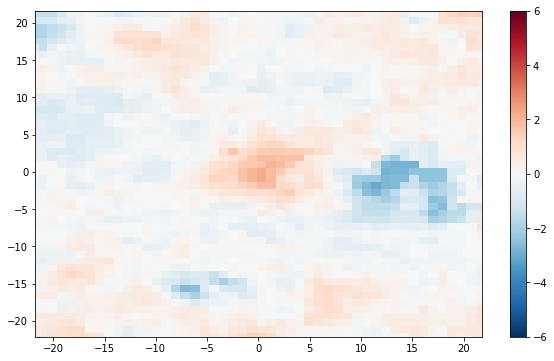

In [48]:
#Night
fig = plt.figure(figsize=(10, 6))
ax=plt.gca()

x_suhi = temp_df.x_points
y_suhi = temp_df.y_points
SUHI = temp_df.SUHI

#get the points into the correct format
X_suhi ,Y_suhi = np.meshgrid(x_suhi ,y_suhi)
Z_suhi = scipy.interpolate.griddata((x_suhi, y_suhi), SUHI, (X_suhi,Y_suhi), method='nearest')

c = ax.pcolormesh(X_suhi,Y_suhi, Z_suhi, cmap ='RdBu_r', vmin=-6, vmax=6)
fig.colorbar(c, ax=ax)

Text(0.5, 1.0, 'SUHI (K), Al_Gadarif, 22.30, 17/06/2020')

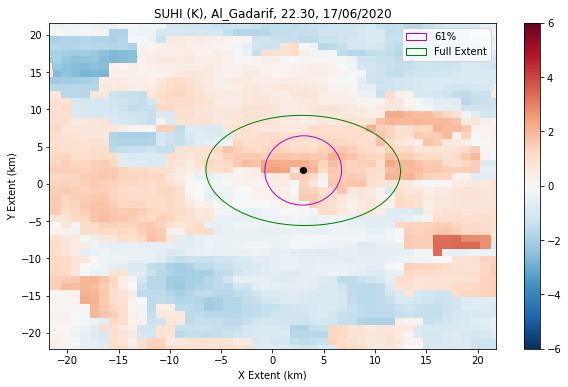

In [19]:
#Make plot with parameters on 
#Colour mesh plot
parameters_night = terra_parameters_night

a0 = parameters_night[parameters_night['Filename'] == choose_file]['night_a0'].values[0]
phi = parameters_night[parameters_night['Filename'] == choose_file]['night_phi'].values[0]

sphi2 = (np.sin(phi))**2
cphi2 = (np.cos(phi))**2
a_x = parameters_night[parameters_night['Filename'] == choose_file]['night_ax'].values[0]
a_y = parameters_night[parameters_night['Filename'] == choose_file]['night_ay'].values[0]
ax2 = a_x **2
ay2 = a_y **2
y0 = parameters_night[parameters_night['Filename'] == choose_file]['night_y0'].values[0]
x0 = parameters_night[parameters_night['Filename'] == choose_file]['night_x0'].values[0]

date = parameters_night[parameters_night['Filename'] == choose_file]['Date'].values[0]
#Function calculates x and y for a given SUHI magnitude
def calc_xy(SUHI):
    yextent = np.sqrt(np.log(SUHI/a0)/(-sphi2/(0.5*ax2)-cphi2/(0.5*ay2))) # yextent is y - y0
    xextent = np.sqrt(np.log(SUHI/a0)/(-cphi2/(0.5*ax2)-sphi2/(0.5*ay2))) # xextent is x- x0
    return [xextent,yextent]

#calculating where the temperature falls within 61% of its maximum value
xextent_61 = np.sqrt(1/(4*(cphi2/ax2 + sphi2/ay2))) # xextent is x - x0 #SUHI/a0 = e**-0.5
yextent_61 = np.sqrt(1/(4*(sphi2/ax2 + cphi2/ay2))) # yextent is y - y0 #SUHI/a0 = e**-0.5

fig = plt.figure(figsize=(10, 6))
ax=plt.gca()

x_suhi = temp_df.x_points
y_suhi = temp_df.y_points
SUHI = temp_df.SUHI

#get the points into the correct format
X_suhi ,Y_suhi = np.meshgrid(x_suhi ,y_suhi)
Z_suhi = scipy.interpolate.griddata((x_suhi, y_suhi), SUHI, (X_suhi,Y_suhi), method='nearest')

c = ax.pcolormesh(X_suhi,Y_suhi, Z_suhi, cmap ='RdBu_r', vmin=-6, vmax=6)
fig.colorbar(c, ax=ax)

ax.plot(x0,y0,'ko') 

ellipse_outer = mpatches.Ellipse((x0,y0), 2*a_x, 2*a_y, angle=phi, fill=False, label = 'Full Extent', edgecolor = 'g')
ellipse = mpatches.Ellipse((x0,y0), 2*xextent_61, 2*yextent_61, angle=phi, fill=False, label = '61%', edgecolor = 'm')
ax.add_patch(ellipse)
ax.add_patch(ellipse_outer)
ax.legend()

plt.xlabel('X Extent (km)')
plt.ylabel('Y Extent (km)')
plt.title('SUHI (K), {}, 22.30, {}'.format(City_name, date))

In [20]:
#Parameters
print('a0:', a0)
print('x0:', x0)
print('y0:', y0)
print('ax:',a_x )
print('ay:', a_y)
print('phi:', phi)

a0: 1.8977175526665755
x0: 2.9999999985679957
y0: 1.7999999999999996
ax: 9.483314633796134
ay: 7.3959495145043235
phi: -1.817461189129574


In [88]:
os.chdir(os.path.join(et.io.HOME))